In [4]:
#importing necessary modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import datetime
import math
# from torch.nn.parameter import Parameter
# from torch.nn.modules.module import Module
import matplotlib.pyplot as plt

In [2]:
from torch import Tensor
from torch.nn import Linear
import datetime

In [3]:
# n_lat_grid = 100
# n_long_grid = 100

# TODO: Add buffer and consider train-data for range
# lat_range = {'min': 28.486, 'max': 28.72}
# long_range = {'min': 77.1, 'max': 77.32}
# area = 21*26 sq km

# Temporal analyis for local buses 

## Pollution distribution

In [ ]:
n_lat_grid_lines = 99
n_long_grid_lines = 99

In [5]:
# took 1 hour time from 9.00 to 10.00AM in consideration for model
hr_start, hr_end = 540, 600

#Put the file location
df = pd.read_csv('2020-12-24_all.csv')

#type casting
df.pm1_0 = df.pm1_0.astype(float)
df.pm2_5 = df.pm2_5.astype(float)
df.pm10 = df.pm10.astype(float)
df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
df.long= round(round(5*df.long.astype(float),2)/5.0,3)

df.dateTime = pd.to_datetime(df.dateTime)

print(len(df))
# Ensuring Delhi region and removing outliers from data
df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]


# df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]

#df = df[(df.humidity<=60)&(df.humidity>=7)]
print(len(df))

# rounding @15min
df.dateTime = df.dateTime.dt.round('15min')

# only PM2_5
dfHour = df[(df['dateTime'].dt.day == 24)][['dateTime','lat','long','pm2_5', 'pm1_0', 'pm10']]

# TODO: Add buffer and consider train-data for range
lat_range = {'min': dfHour.lat.min(), 'max': dfHour.lat.max()}
long_range = {'min': dfHour.long.min(), 'max': dfHour.long.max()}

print(lat_range)
print(long_range)

dfHour['lat_grid'] = dfHour.apply(lambda row: int(n_lat_grid_lines*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
dfHour['long_grid'] = dfHour.apply(lambda row: int(n_long_grid_lines*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
dfHour['lat_grid'] = dfHour['lat_grid'].astype(float).astype(int)
dfHour['long_grid'] = dfHour['long_grid'].astype(float).astype(int)
del dfHour['lat']
del dfHour['long']

print(dfHour.head())

# TODO: use time as a feature as well
# converting time to minutes and selecting a one hour slot for 9.00AM to 10.00AM
dfHour.dateTime = dfHour.dateTime.dt.hour*60 + dfHour.dateTime.dt.minute 
print(dfHour.head())
# dfHour = dfHour[(dfHour.dateTime>=hr_start) & (dfHour.dateTime<=hr_end)] 

print(dfHour.head())


164896
164896
{'min': 28.49, 'max': 28.674}
{'min': 77.122, 'max': 77.32}
                   dateTime  pm2_5  pm1_0   pm10  lat_grid  long_grid
0 2020-12-24 00:00:00+05:30  361.0  202.0  413.0        30         78
1 2020-12-24 00:00:00+05:30  342.0  206.0  349.0        48         56
2 2020-12-24 00:00:00+05:30  359.0  202.0  415.0        30         78
3 2020-12-24 00:00:00+05:30  342.0  205.0  348.0        48         56
4 2020-12-24 00:00:00+05:30  358.0  202.0  414.0        30         78
   dateTime  pm2_5  pm1_0   pm10  lat_grid  long_grid
0         0  361.0  202.0  413.0        30         78
1         0  342.0  206.0  349.0        48         56
2         0  359.0  202.0  415.0        30         78
3         0  342.0  205.0  348.0        48         56
4         0  358.0  202.0  414.0        30         78
   dateTime  pm2_5  pm1_0   pm10  lat_grid  long_grid
0         0  361.0  202.0  413.0        30         78
1         0  342.0  206.0  349.0        48         56
2         0  359.0  

In [7]:
time = []
pm2_5 = []
pm1_0 = []
pm10 = []
# dateTime = dfHour.at[0,'dateTime']
# print(dateTime)
pm2_5_temp = 0
pm1_0_temp = 0
pm10_temp = 0
count = 0
for i,row in dfHour.iterrows():
    if i==0:
        dateTime = row.dateTime
    if row.dateTime == dateTime:
        pm2_5_temp += row.pm2_5
        pm1_0_temp += row.pm1_0
        pm10_temp += row.pm10
        count += 1
    else:
        time.append(dateTime)
        pm2_5.append(pm2_5_temp/count)
        pm1_0.append(pm1_0_temp/count)
        pm10.append(pm10_temp/count)
        dateTime = row.dateTime
        pm2_5_temp = row.pm2_5
        pm1_0_temp = row.pm1_0
        pm10_temp = row.pm10
        count = 1
time.append(dateTime)
pm2_5.append(pm2_5_temp/count)
pm1_0.append(pm1_0_temp/count)
pm10.append(pm10_temp/count)


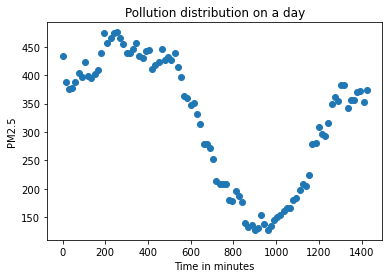

In [11]:
plt.scatter(time, pm2_5)
plt.title("Pollution distribution on a day")
plt.xlabel("Time in minutes")
plt.ylabel("PM2.5")
plt.show()

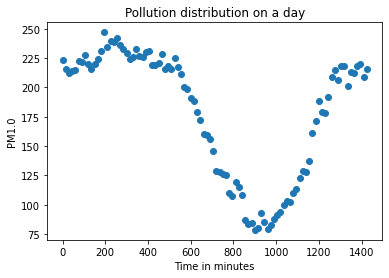

In [12]:
plt.scatter(time, pm1_0)
plt.title("Pollution distribution on a day")
plt.xlabel("Time in minutes")
plt.ylabel("PM1.0")
plt.show()

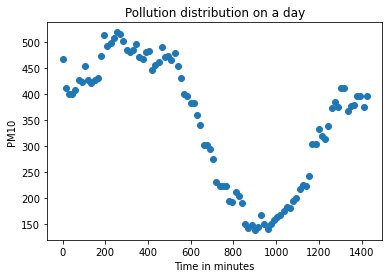

In [13]:
plt.scatter(time, pm10)
plt.title("Pollution distribution on a day")
plt.xlabel("Time in minutes")
plt.ylabel("PM10")
plt.show()

In [82]:
def avg_pm(datafile, day, hr_start, hr_end):
    # took 1 hour time from 9.00 to 10.00AM in consideration for model
#     hr_start, hr_end = 540, 600

    #Put the file location
    df = pd.read_csv(datafile)

    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    df.dateTime = pd.to_datetime(df.dateTime)

    # print(len(df))
    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]

    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]

    #df = df[(df.humidity<=60)&(df.humidity>=7)]
    # print(len(df))
    # rounding @15min
    df.dateTime = df.dateTime.dt.round('15min')

    # only PM2_5
    dfHour = df[(df['dateTime'].dt.day == day)][['dateTime','lat','long','pm2_5', 'pm1_0', 'pm10']]

    # TODO: use time as a feature as well
    # converting time to minutes and selecting a one hour slot for 9.00AM to 10.00AM
    dfHour.dateTime = dfHour.dateTime.dt.hour*60 + dfHour.dateTime.dt.minute 
    dfHour = dfHour[(dfHour.dateTime>=hr_start) & (dfHour.dateTime<=hr_end)] 

#     print(dfHour.head())
    pm2_5 = dfHour['pm2_5'].sum()/dfHour['pm2_5'].size
    pm1_0 = dfHour['pm1_0'].sum()/dfHour['pm1_0'].size
    pm10 = dfHour['pm10'].sum()/dfHour['pm10'].size
    return pm2_5, pm1_0, pm10

In [83]:
pm2_5 = []
pm1_0 = [] 
pm10 = []
day = []
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    
    pm2_5_temp, pm1_0_temp, pm10_temp = avg_pm(datafile = datafile, day = i, hr_start = 540, hr_end = 600)
    pm2_5.append(pm2_5_temp)
    pm1_0.append(pm1_0_temp)
    pm10.append(pm10_temp)
    day.append(i)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


[360.0199089874858, nan, 167.89585666293394, 218.22377060163473, 302.2304, 319.9364705882353, 492.77777777777777, 391.241935483871, 470.59708737864077, 697.1807228915662, 223.37894736842105, 278.92216632139684, 284.2621869623399, 455.44756944444447, 275.624279737943, 106.1044776119403, 124.77954371897671, 157.31323611890073, 178.3777142857143, 192.45976086456656, 197.74425682309052, 208.56807832422587, 252.9392389525368, 324.0479041916168, 302.6065075921909, 98.4025, 110.5862705864245, 141.56427125506073, 178.20601503759397, 193.9497262319562]


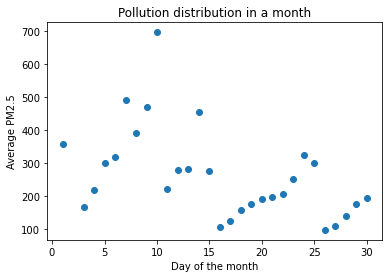

In [84]:
# indices = {0, 7, 14, 21, 28}
# day = [day[i] for i in indices]
# pm2_5 = [pm2_5[i] for i in indices]
plt.scatter(day, pm2_5)
plt.title("Pollution distribution in a month")
plt.xlabel("Day of the month")
plt.ylabel("Average PM2.5")
print(pm2_5)
plt.show()

In [87]:
pm2_5 = []
pm1_0 = [] 
pm10 = []
day = []
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    
    pm2_5_temp, pm1_0_temp, pm10_temp = avg_pm(datafile = datafile, day = i, hr_start = 1080, hr_end = 1140)
    pm2_5.append(pm2_5_temp)
    pm1_0.append(pm1_0_temp)
    pm10.append(pm10_temp)
    day.append(i)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


[112.59344385832705, nan, 111.85539179921203, 448.0699726194098, 230.31555555555556, 210.50907029478458, 169.03636363636363, 293.5483870967742, 504.1781045751634, nan, 138.779262086514, 150.71948682385576, 159.62243254128072, 426.47308347529815, 162.3639322186062, 107.59507477791522, 81.83393177737881, 145.1350052927286, 138.3268967874231, 111.45515187611673, 110.0472945345509, 120.80740591668344, 237.4434095399379, 248.6572327044025, 302.8734693877551, 70.78604193971167, 94.01865183246073, 114.453125, 157.16487455197134, 183.53737373737374]


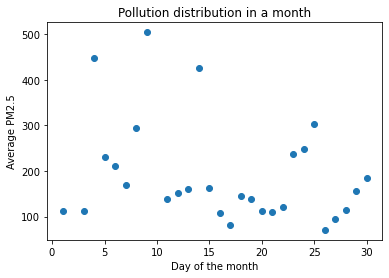

[4, 9, 14, 25]


In [96]:
plt.scatter(day, pm2_5)
print(pm2_5)
plt.title("Pollution distribution in a month")
plt.xlabel("Day of the month")
plt.ylabel("Average PM2.5")
plt.show()
high_pm = []
for i in range(len(pm2_5)):
    if pm2_5[i]>300:
        high_pm.append(i+1)
print(high_pm)

In [97]:
pm2_5 = []
pm1_0 = [] 
pm10 = []
day = []
for i in range(1, 32):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    
    pm2_5_temp, pm1_0_temp, pm10_temp = avg_pm(datafile = datafile, day = i, hr_start = 1080, hr_end = 1140)
    pm2_5.append(pm2_5_temp)
    pm1_0.append(pm1_0_temp)
    pm10.append(pm10_temp)
    day.append(i)

[264.414010989011, 171.73007518796993, 300.25223613595705, 237.5656194750442, 240.0727668845316, 204.85432098765432, 226.58960417572857, 187.037088873338, 148.36017794140204, 144.01214627212818, 162.21813045711352, 286.0016855826497, 92.97429163787146, 121.85909172500449, 148.01854256268766, 146.1664152257166, 176.1374528219082, 147.20152276040824, 167.70038317940657, 172.988808697241, 193.97029702970298, 228.90556279878314, 227.22739018087856, 194.4610374505699, 156.9821614312461, 212.1836136915223, 229.05324940455938, 85.45402758344993, 110.7749242533545, 190.32754709537429, 245.26379146098554]


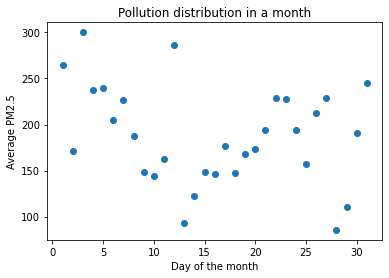

[3]


In [98]:
plt.scatter(day, pm2_5)
print(pm2_5)
plt.title("Pollution distribution in a month")
plt.xlabel("Day of the month")
plt.ylabel("Average PM2.5")
plt.show()
high_pm = []
for i in range(len(pm2_5)):
    if pm2_5[i]>300:
        high_pm.append(i+1)
print(high_pm)

## Hourly pollution analysis for local buses

In [3]:
def day_analysis(datafile, day):
    df = pd.read_csv(datafile)

    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)
    df.dateTime = pd.to_datetime(df.dateTime)
    df = df[(df['dateTime'].dt.day == day)][['dateTime','lat','long','pm2_5', 'pm1_0', 'pm10']]
    df_mean = df.groupby([df['dateTime'].dt.hour]).mean()['pm2_5']
    df_std = df.groupby([df['dateTime'].dt.hour]).std()['pm2_5']
    if(len(df_mean)<24):
        d = pd.Series(0, index=np.arange(24-len(df_mean)))
        df_mean = df_mean.append(d, ignore_index=True)
        df_std = df_std.append(d, ignore_index=True)

    return df_mean, df_std

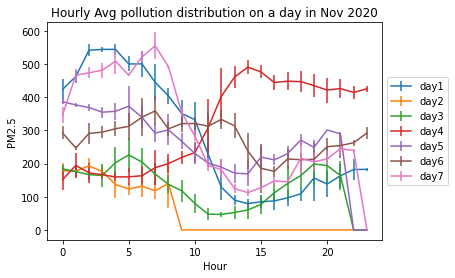

In [26]:
hour = np.arange(0, 24, 1)
for i in range(1, 8):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg pollution distribution on a day in Nov 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

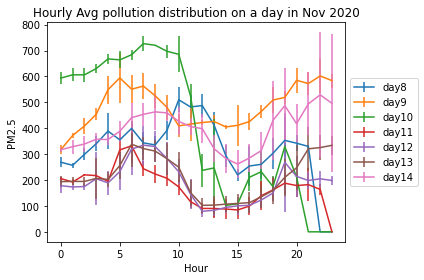

In [27]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(8, 15):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Nov 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

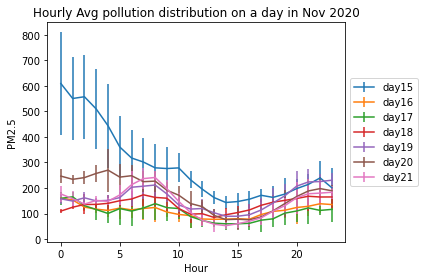

In [28]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(15, 22):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Nov 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

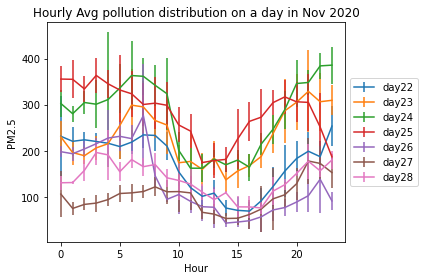

In [29]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(22, 29):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Nov 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

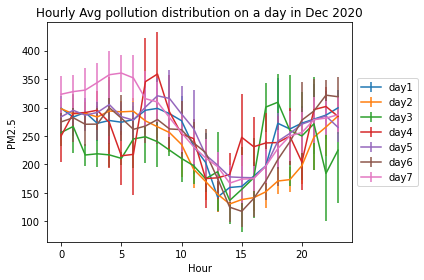

In [4]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(1, 8):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Dec 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

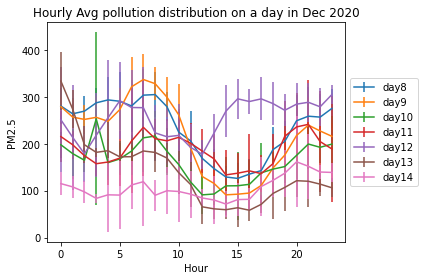

In [5]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(8, 15):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Dec 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

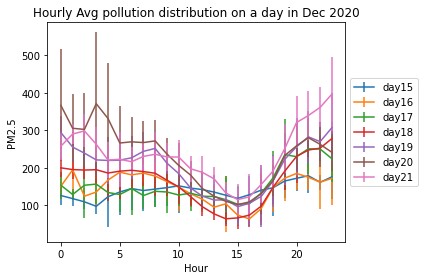

In [6]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(15, 22):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Dec 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

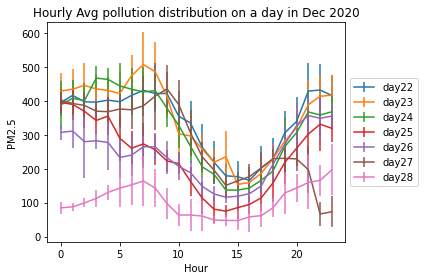

In [7]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(22, 29):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Dec 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

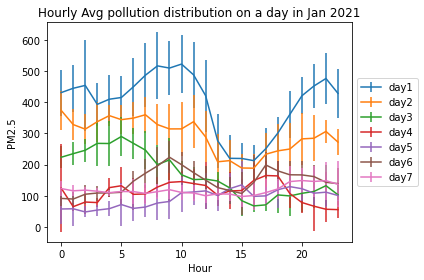

In [8]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(1, 8):
    if i<10:
        datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Jan 2021")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

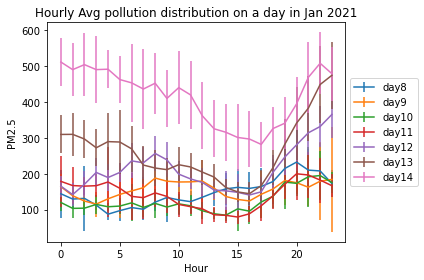

In [9]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(8, 15):
    if i<10:
        datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Jan 2021")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

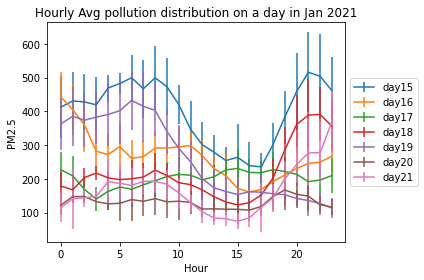

In [10]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(15, 22):
    if i<10:
        datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Jan 2021")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

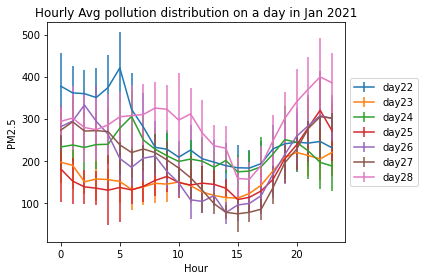

In [11]:
hour = np.arange(0, 24, 1)
# plt.figure(figsize=(8, 6))
for i in range(22, 29):
    if i<10:
        datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
    
    df_mean, df_std = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Hourly Avg pollution distribution on a day in Jan 2021")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.tight_layout()
plt.show()

## Monthly pollution analysis for local buses

In [31]:
def monthly_analysis(datafile, day):
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)
    df.dateTime = pd.to_datetime(df.dateTime)
    df = df[(df['dateTime'].dt.day == day)][['dateTime','lat','long','pm2_5', 'pm1_0', 'pm10']]
    df_mean = df['pm2_5'].mean()
    df_std = df['pm2_5'].std()
    
    return df_mean, df_std

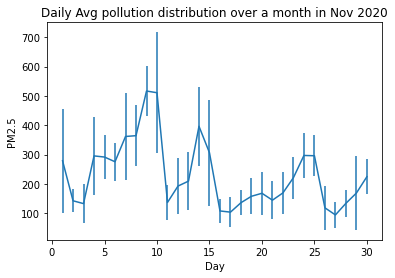

In [43]:
day = np.arange(1, 31, 1)
means = []
stds = []
# plt.figure(figsize=(8, 6))
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    
    df_mean, df_std = monthly_analysis(datafile, i)
    means.append(df_mean)
    stds.append(df_std)
plt.errorbar(day, means, yerr= stds)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Daily Avg pollution distribution over a month in Nov 2020")
plt.xlabel("Day")
plt.ylabel("PM2.5")
# plt.tight_layout()
plt.show()

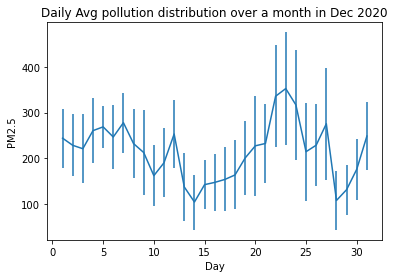

In [44]:
day = np.arange(1, 32, 1)
means = []
stds = []
# plt.figure(figsize=(8, 6))
for i in range(1, 32):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    
    df_mean, df_std = monthly_analysis(datafile, i)
    means.append(df_mean)
    stds.append(df_std)
plt.errorbar(day, means, yerr= stds)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Daily Avg pollution distribution over a month in Dec 2020")
plt.xlabel("Day")
plt.ylabel("PM2.5")
# plt.tight_layout()
plt.show()

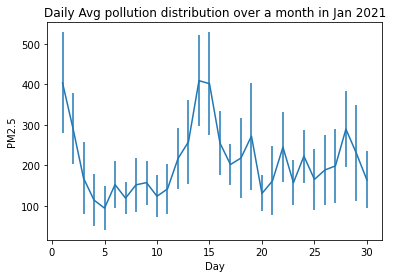

In [46]:
day = np.arange(1, 31, 1)
means = []
stds = []
# plt.figure(figsize=(8, 6))
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
    
    df_mean, df_std = monthly_analysis(datafile, i)
    means.append(df_mean)
    stds.append(df_std)
plt.errorbar(day, means, yerr= stds)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Daily Avg pollution distribution over a month in Jan 2021")
plt.xlabel("Day")
plt.ylabel("PM2.5")
# plt.tight_layout()
plt.show()

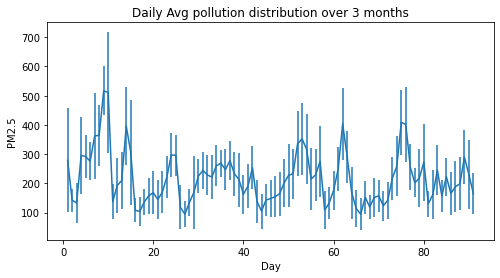

In [48]:
day = np.arange(1, 92, 1)
means = []
stds = []
# plt.figure(figsize=(8, 6))
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    
    df_mean, df_std = monthly_analysis(datafile, i)
    means.append(df_mean)
    stds.append(df_std)
for i in range(1, 32):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    
    df_mean, df_std = monthly_analysis(datafile, i)
    means.append(df_mean)
    stds.append(df_std)
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
    
    df_mean, df_std = monthly_analysis(datafile, i)
    means.append(df_mean)
    stds.append(df_std)
plt.figure(figsize=(8, 4))    
plt.errorbar(day, means, yerr= stds)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.title("Daily Avg pollution distribution over 3 months")
plt.xlabel("Day")
plt.ylabel("PM2.5")
# plt.tight_layout()
plt.show()

# Temporal analyis for static sensors

In [96]:
#importing necessary modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import datetime
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import matplotlib.pyplot as plt
from torch import Tensor
from torch.nn import Linear
import datetime

In [170]:
def day_analysis(datafile, day):
    df = pd.read_csv(datafile)

    #type casting
    df.value = df.value.astype(float)
    df.latitude = round(round(5*df.latitude.astype(float),2)/5.0,3)
    df.longitude= round(round(5*df.longitude.astype(float),2)/5.0,3)
    df.local = pd.to_datetime(df.local)
    df = df[(df['local'].dt.day == day)][['local','latitude','longitude','value']]
    df_mean = df.groupby([df['local'].dt.hour]).mean()['value']
    df_std = df.groupby([df['local'].dt.hour]).std()['value']
    hour = df_mean.index.tolist()
#     for i in range(0,24):
#         if i not in df_mean.index.tolist():
#             df_mean[i] = None
#             df_std[i] = None
#     df_mean = df_mean.sort_index()
#     df_std = df_std.sort_index()
    return df_mean, df_std, hour

In [171]:
df = pd.read_csv('static_sensor_data/2020-11-01.csv')

In [172]:
df.head()

Unnamed: 0  locationId                          location   city country  \
0           0       10485              Narela, Delhi - DPCC  Delhi      IN   
1           1       10484  Sri Aurobindo Marg, Delhi - DPCC  Delhi      IN   
2           2        6931    Dwarka-Sector 8, Delhi - DPCC   Delhi      IN   
3           3       10488           Najafgarh, Delhi - DPCC  Delhi      IN   
4           4        8917         Ashok Vihar, Delhi - DPCC  Delhi      IN   

                       local parameter  value   unit   latitude  longitude  
0  2020-11-01 10:45:00+05:30      pm25  355.0  µg/m³  28.822836  77.101981  
1  2020-11-01 10:45:00+05:30      pm25  289.0  µg/m³  28.531346  77.190156  
2  2020-11-01 11:00:00+05:30      pm25  250.0  µg/m³  28.571027  77.071901  
3  2020-11-01 11:00:00+05:30      pm25  224.0  µg/m³  28.570173  76.933762  
4  2020-11-01 11:00:00+05:30      pm25  299.0  µg/m³  28.695381  77.181665

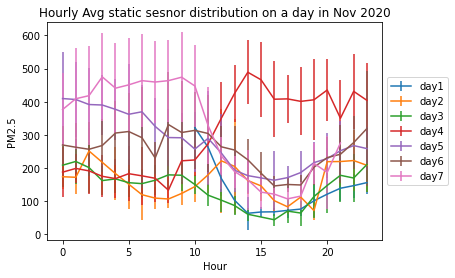

In [173]:
# hour = np.arange(0, 24, 1)
for i in range(1, 8):
    if i<10:
        datafile = 'static_sensor_data/2020-11-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2020-11-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Nov 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

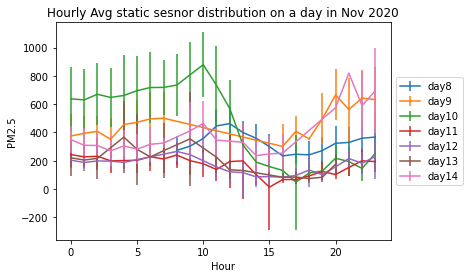

In [176]:
hour = np.arange(0, 24, 1)
for i in range(8, 15):
    if i<10:
        datafile = 'static_sensor_data/2020-11-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2020-11-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Nov 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

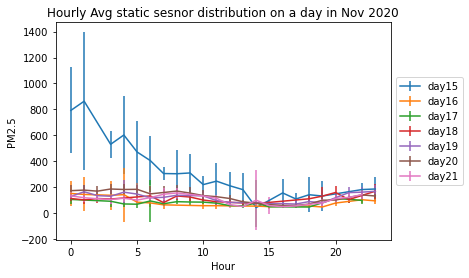

In [177]:
hour = np.arange(0, 24, 1)
for i in range(15, 22):
    if i<10:
        datafile = 'static_sensor_data/2020-11-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2020-11-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Nov 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

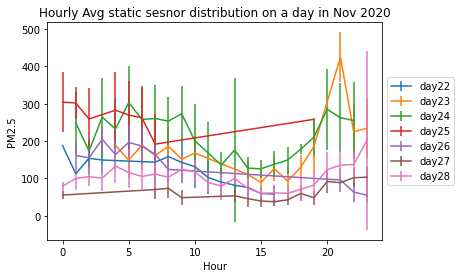

In [178]:
hour = np.arange(0, 24, 1)
for i in range(22, 29):
    if i<10:
        datafile = 'static_sensor_data/2020-11-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2020-11-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Nov 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

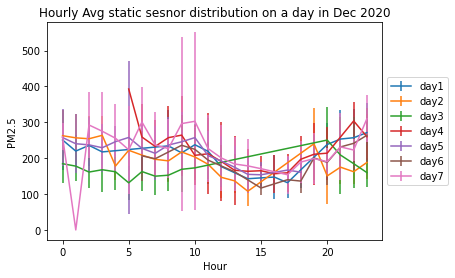

In [180]:
hour = np.arange(0, 24, 1)
for i in range(1, 8):
    if i<10:
        datafile = 'static_sensor_data/2020-12-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2020-12-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Dec 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

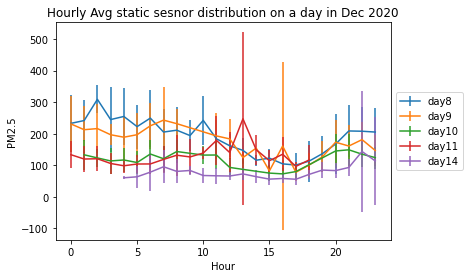

In [181]:
hour = np.arange(0, 24, 1)
for i in range(8, 15):
    if i==12 or i==13:
        continue
    if i<10:
        datafile = 'static_sensor_data/2020-12-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2020-12-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Dec 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

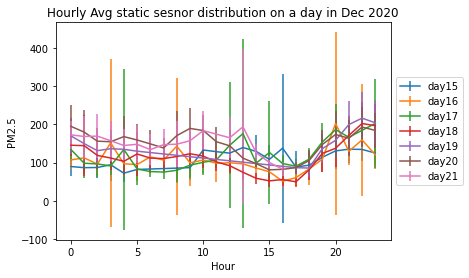

In [182]:
hour = np.arange(0, 24, 1)
for i in range(15, 22):
    if i<10:
        datafile = 'static_sensor_data/2020-12-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2020-12-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Dec 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

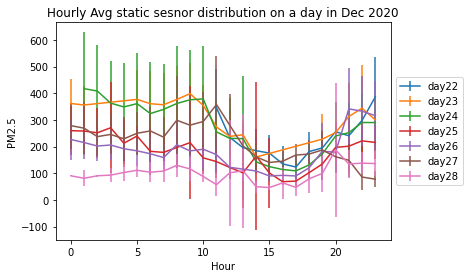

In [183]:
hour = np.arange(0, 24, 1)
for i in range(22, 29):
    if i<10:
        datafile = 'static_sensor_data/2020-12-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2020-12-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Dec 2020")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

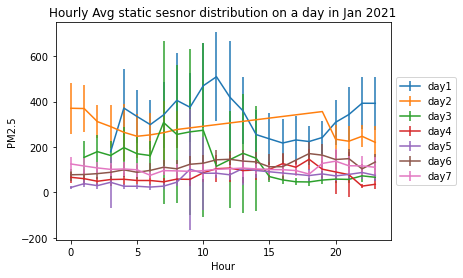

In [184]:
hour = np.arange(0, 24, 1)
for i in range(1, 8):
    if i<10:
        datafile = 'static_sensor_data/2021-01-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2021-01-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Jan 2021")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

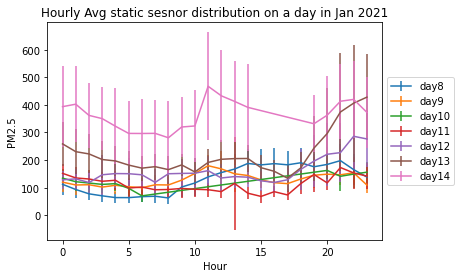

In [185]:
hour = np.arange(0, 24, 1)
for i in range(8, 15):
    if i<10:
        datafile = 'static_sensor_data/2021-01-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2021-01-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Jan 2021")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

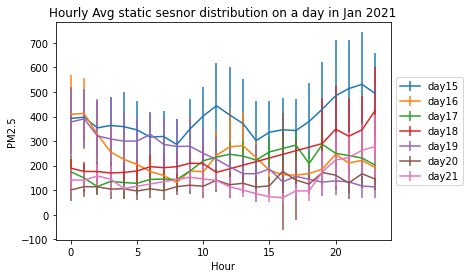

In [186]:
hour = np.arange(0, 24, 1)
for i in range(15, 22):
    if i<10:
        datafile = 'static_sensor_data/2021-01-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2021-01-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Jan 2021")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

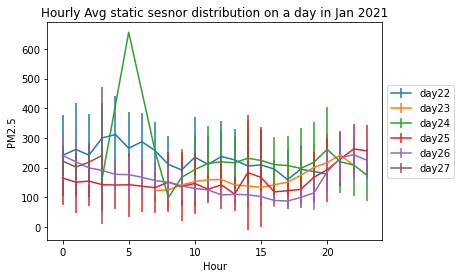

In [187]:
hour = np.arange(0, 24, 1)
for i in range(22, 28):
    if i<10:
        datafile = 'static_sensor_data/2021-01-' + str(0) + str(i) + '.csv'
    else:
        datafile = 'static_sensor_data/2021-01-' + str(i) + '.csv'
    
    df_mean, df_std, hour = day_analysis(datafile, i)
    plt.errorbar(hour, df_mean, yerr= df_std, label = 'day'+str(i))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))     
plt.title("Hourly Avg static sesnor distribution on a day in Jan 2021")
plt.xlabel("Hour")
plt.ylabel("PM2.5")
plt.show()

# Spatial Data Analysis

In [55]:
#importing necessary modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import datetime
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import matplotlib.pyplot as plt
from torch import Tensor
from torch.nn import Linear
import datetime

In [56]:
df = pd.read_csv('PM Datasets/2020-11-04_all.csv')

In [57]:
df

Unnamed: 0                                   uid  \
0               0  be3422ae-5386-4204-b263-983fee363e05   
1               1  9551e870-167f-42d3-a9fa-7740be9bc985   
2               2  f58a89e9-af35-4275-bec4-65b1a4f16240   
3               3  c213613e-d9bb-45ca-9cb6-ab69ba8fb321   
4               4  d5aa6f43-69cd-458e-8aa7-7fc4840e4fd2   
...           ...                                   ...   
81074       81074  75044a71-761b-46c4-b0d3-9078c481862d   
81075       81075  9649266d-f983-4eb4-90ac-85de758385f7   
81076       81076  0940eb0d-5e64-428b-a429-3f3462b38e8b   
81077       81077  6bcc545e-a579-4ff3-a3ac-338e1a88866c   
81078       81078  cf9d611c-2f4d-4d39-994b-b5a2e9385080   

                        dateTime          deviceId        lat       long  \
0      2020-11-04 00:00:01+05:30  00000000c37f0aa8  28.579390  77.229965   
1      2020-11-04 00:00:02+05:30  10000000dc5bb76b  28.579390  77.230480   
2      2020-11-04 00:00:03+05:30  00000000078e6811  28.579432  77.232262   
3      2020-11-04 00:00:04+05:30  00000000c37f0aa8  28.579404  77.229959   
4      2020-11-04 00:00:06+05:30  00000000c37f0aa8  28.579414  77.229956   
...                          ...               ...        ...        ...   
81074  2020-11-04 23:23:21+05:30  00000000d4bc37f2  28.579268  77.234886   
81075  2020-11-04 23:23:24+05:30  00000000d4bc37f2  28.579273  77.234886   
81076  2020-11-04 23:23:26+05:30  00000000d4bc37f2  28.579276  77.234886   
81077  2020-11-04 23:23:29+05:30  00000000d4bc37f2  28.579281  77.234886   
81078  2020-11-04 23:23:31+05:30  00000000d4bc37f2  28.579284  77.234886   

       pm1_0  pm2_5   pm10  
0       96.0  142.0  148.0  
1       88.0  145.0  169.0  
2       90.0  130.0  138.0  
3       94.0  139.0  146.0  
4       91.0  140.0  146.0  
...      ...    ...    ...  
81074  234.0  427.0  455.0  
81075  235.0  429.0  459.0  
81076  236.0  426.0  454.0  
81077  237.0  429.0  455.0  
81078  235.0  428.0  453.0  

[81079 rows x 9 columns]

In [127]:
df = pd.read_csv('PM Datasets/2020-12-04_all.csv')
#type casting
df.pm2_5 = df.pm2_5.astype(float)
df.dateTime = pd.to_datetime(df.dateTime)
df = df[(df['dateTime'].dt.day == 4)][['dateTime','lat','long','pm2_5']]
df = df[df['dateTime'].dt.hour == 7]
df_mean = df.groupby([df['dateTime'].dt.hour]).mean()['pm2_5']
df_std = df.groupby([df['dateTime'].dt.hour]).std()['pm2_5']
means = df_mean[df['dateTime'].dt.hour].to_numpy()
stds = df_std[df['dateTime'].dt.hour].to_numpy()
pm = df['pm2_5'].to_numpy()
high = pm - means > stds
low = pm - means < -stds
med = (pm - means < stds) & (pm - means > -stds)
df1 = df[['lat', 'long']][high]
df2 = df[['lat', 'long']][low]
df3 = df[['lat', 'long']][med]

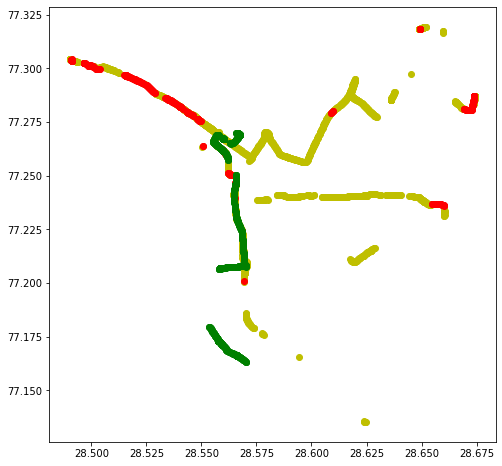

In [138]:
plt.figure(figsize=(8, 8))
plt.scatter(df3['lat'], df3['long'], c = 'y')
plt.scatter(df1['lat'], df1['long'], c = 'r')
plt.scatter(df2['lat'], df2['long'], c = 'g')

In [202]:
def hourly_spatial(datafile, year, month, day, hour):
    df = pd.read_csv(datafile)
    #type casting
    df.pm2_5 = df.pm2_5.astype(float)
    df.dateTime = pd.to_datetime(df.dateTime)
    df = df[(df['dateTime'].dt.day == day)][['dateTime','lat','long','pm2_5']]
    df = df[df['dateTime'].dt.hour == hour]
    df_mean = df.groupby([df['dateTime'].dt.hour]).mean()['pm2_5']
    df_std = df.groupby([df['dateTime'].dt.hour]).std()['pm2_5']
    means = df_mean[df['dateTime'].dt.hour].to_numpy()
    stds = df_std[df['dateTime'].dt.hour].to_numpy()
    pm = df['pm2_5'].to_numpy()
    high = pm - means > stds
    low = pm - means < -stds
    med = (pm - means < stds) & (pm - means > -stds)
    df1 = df[['lat', 'long']][high]
    df2 = df[['lat', 'long']][low]
    df3 = df[['lat', 'long']][med]
    plt.figure(figsize=(6, 6))
    plt.scatter(df3['lat'], df3['long'], c = 'y')
    plt.scatter(df1['lat'], df1['long'], c = 'r')
    plt.scatter(df2['lat'], df2['long'], c = 'g')
    plt.title('Spatial PM distribution over Hour' + str(hour))
    if i<10:
        str_day = '0' + str(i)
    else:
        str_day = str(i)
    plt.savefig('Spatial plots/Hour ' + str(hour) +'/' + str(year) + '-' + str(month) + '-' + str_day + '.png')

## Daily spatial analysis for Hour 7

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


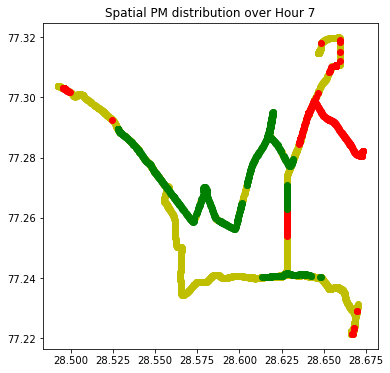

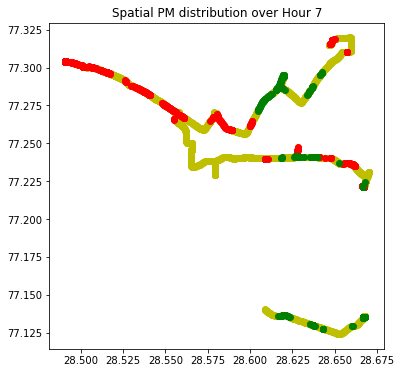

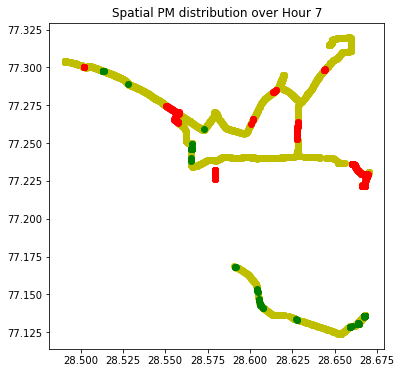

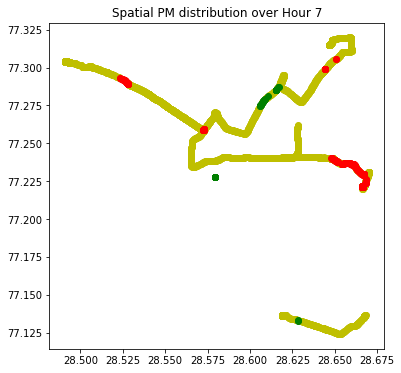

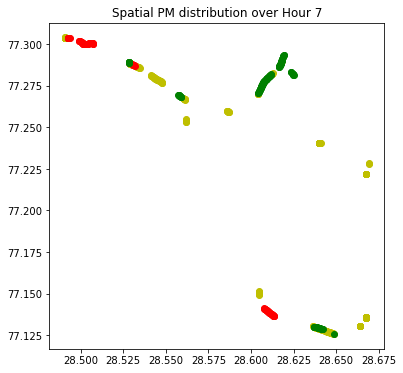

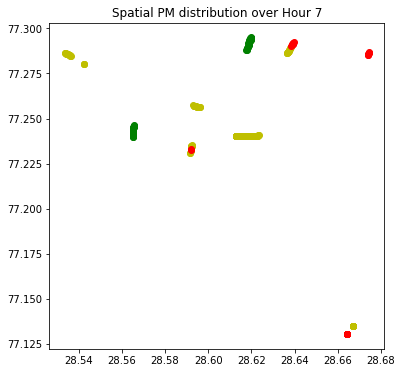

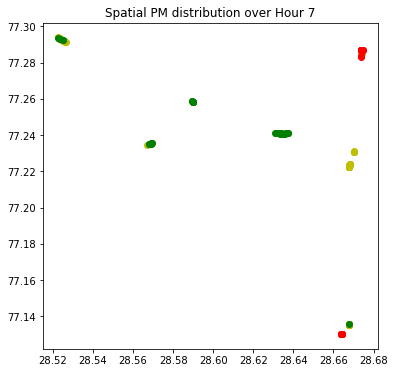

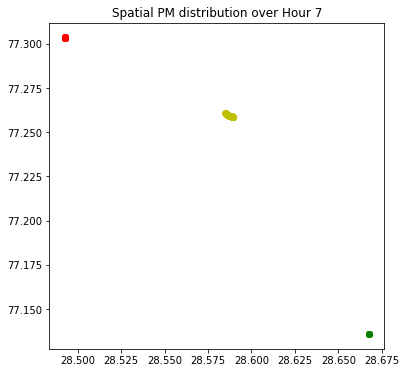

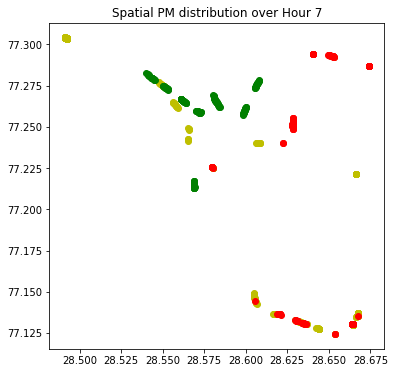

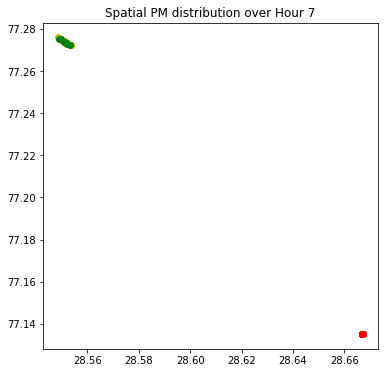

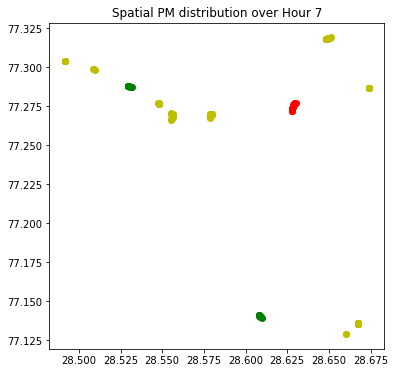

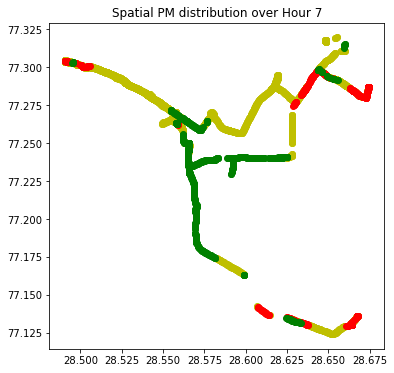

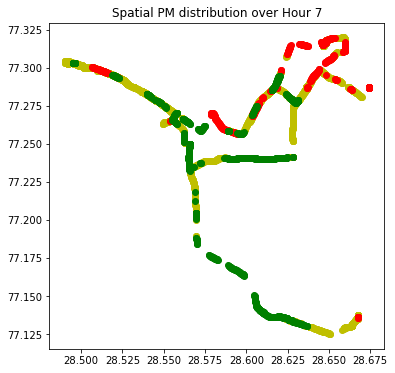

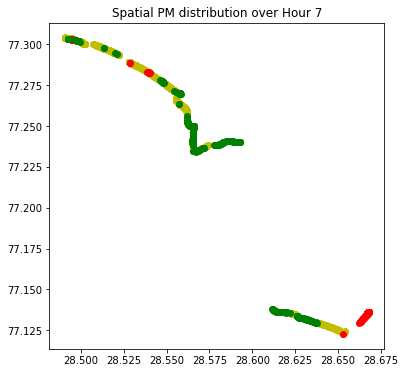

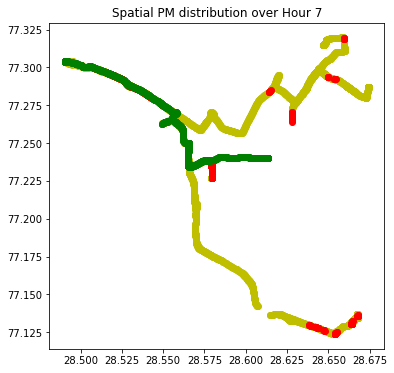

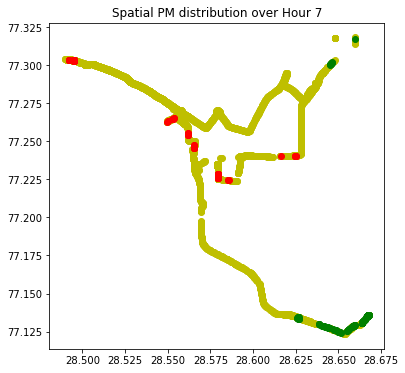

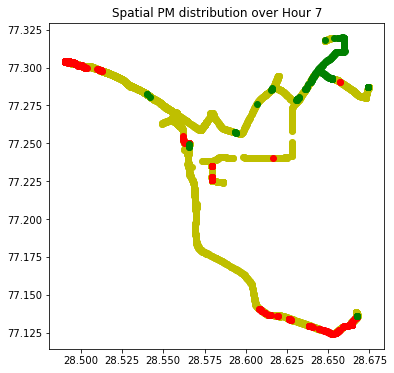

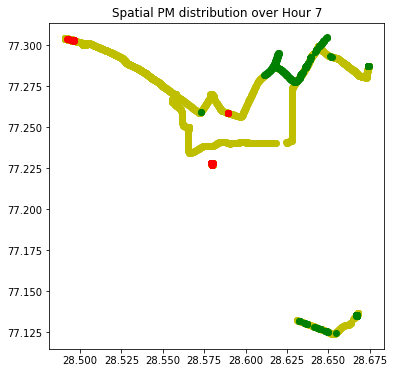

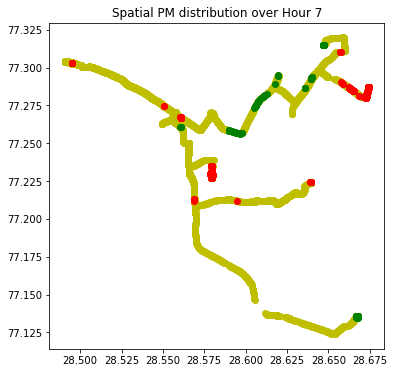

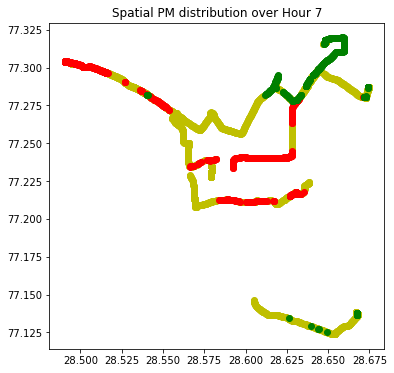

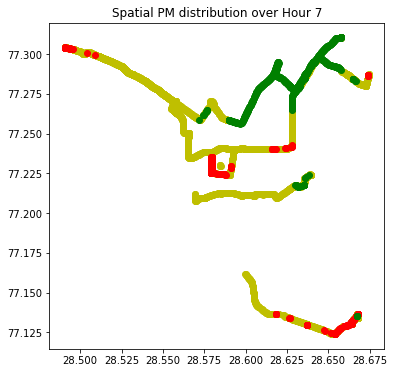

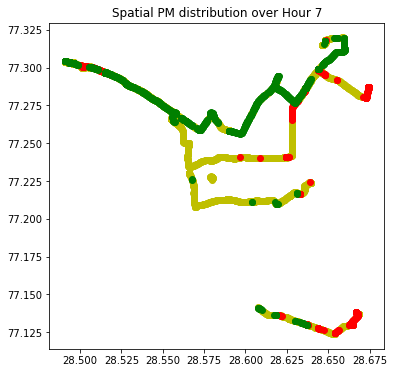

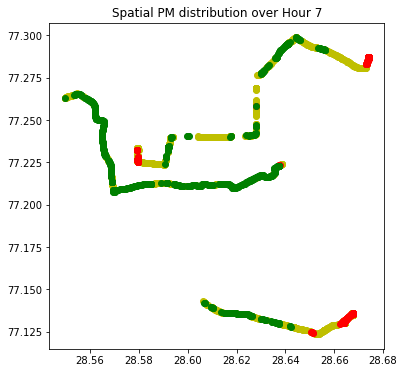

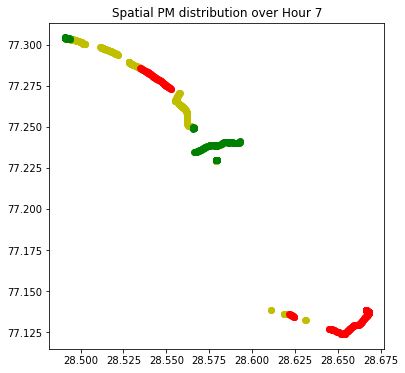

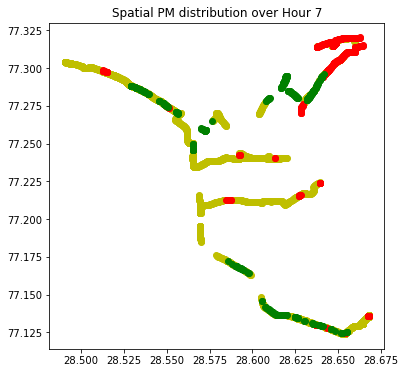

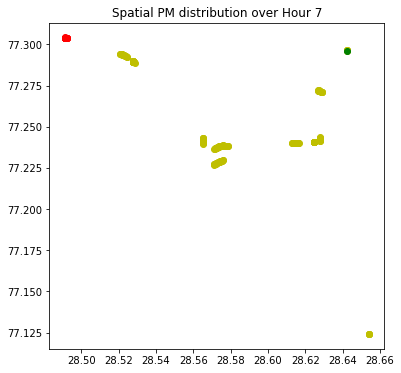

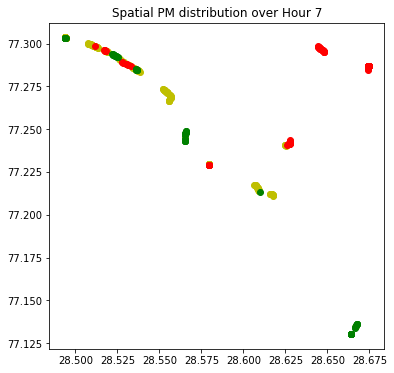

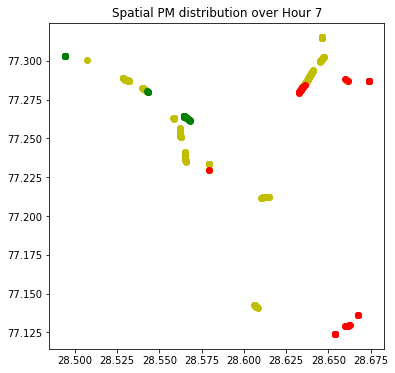

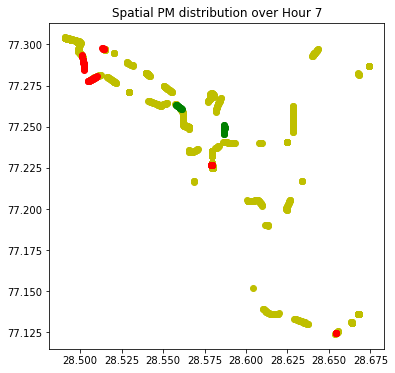

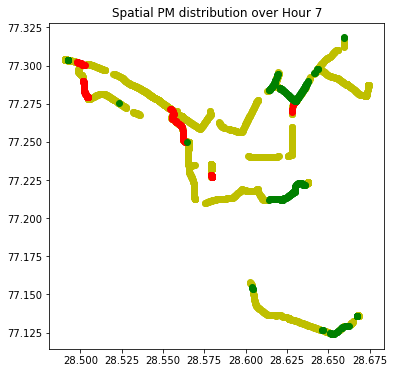

In [181]:
# plt.figure(figsize=(8, 6))
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    hourly_spatial(datafile, 2020, 11, i, 7)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


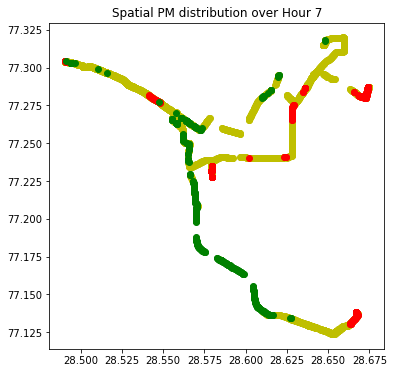

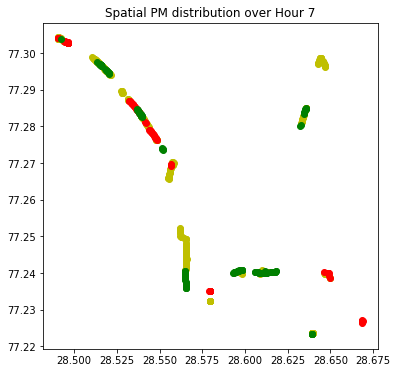

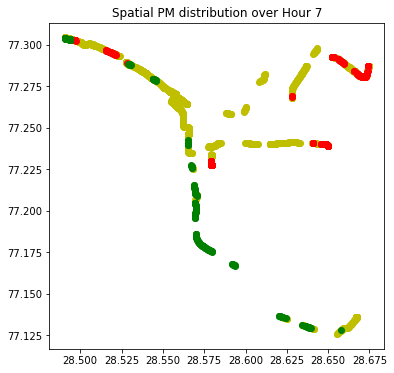

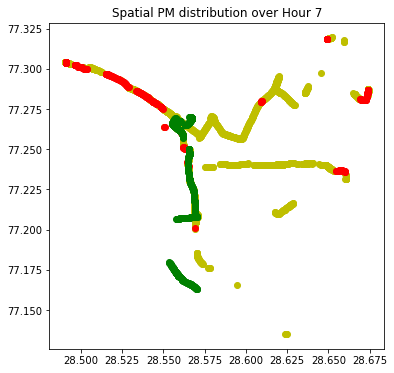

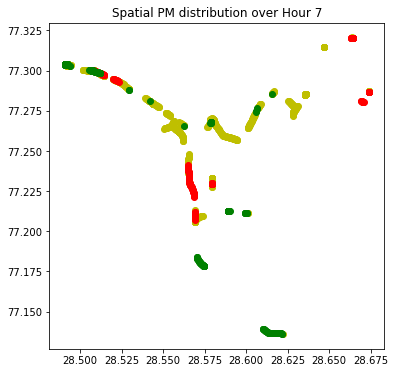

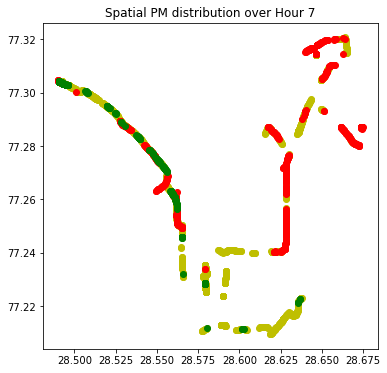

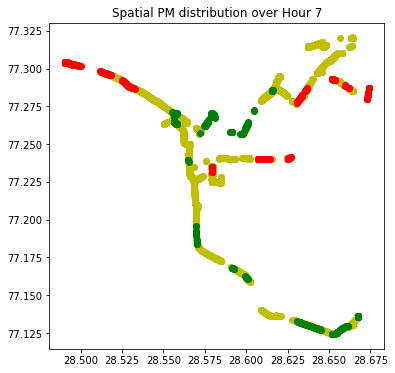

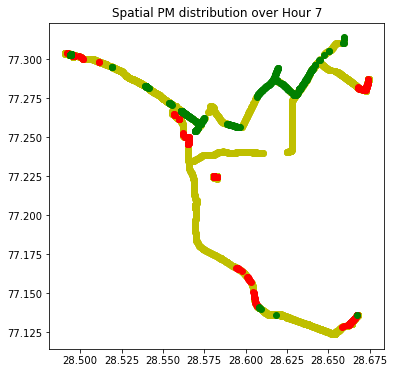

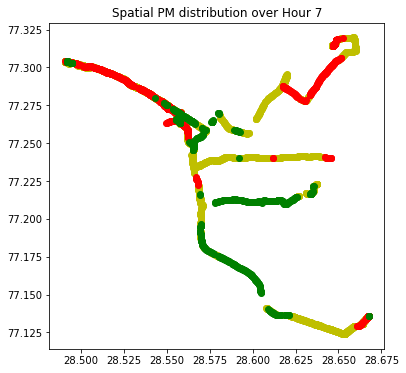

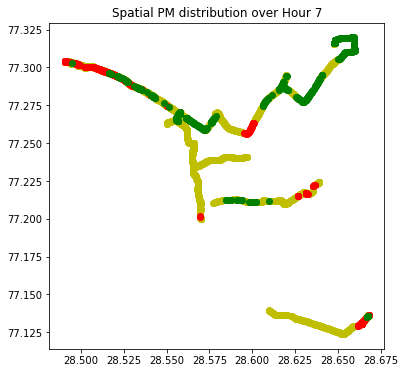

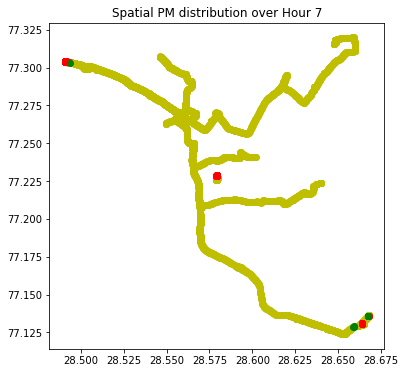

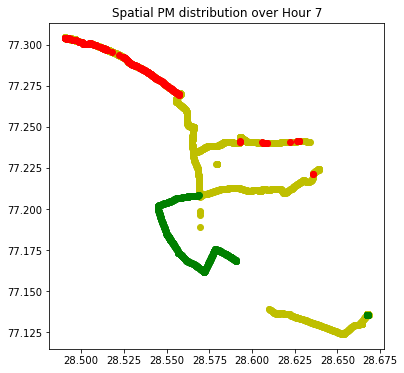

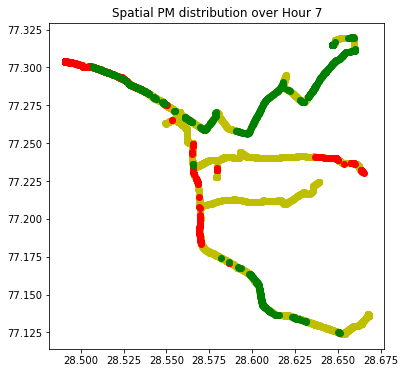

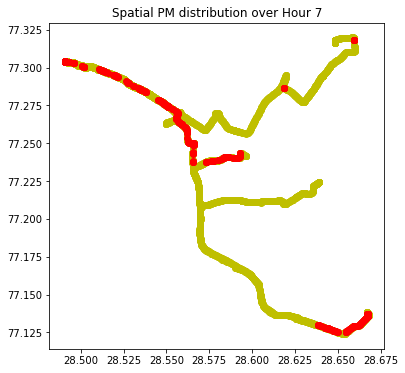

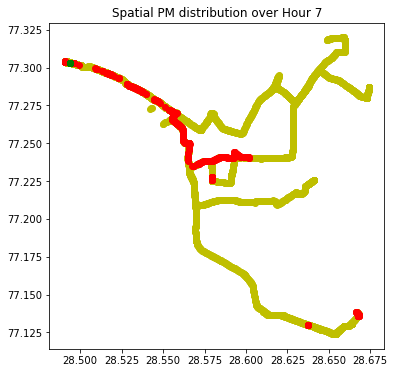

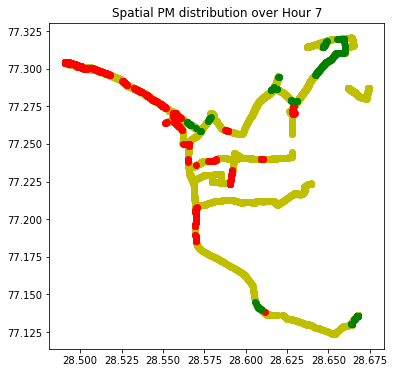

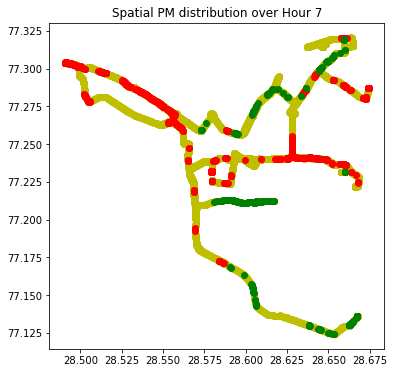

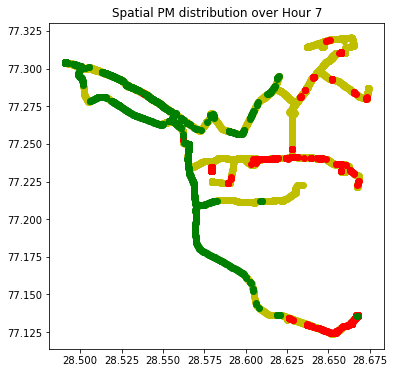

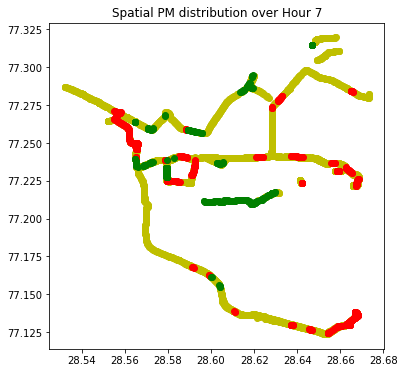

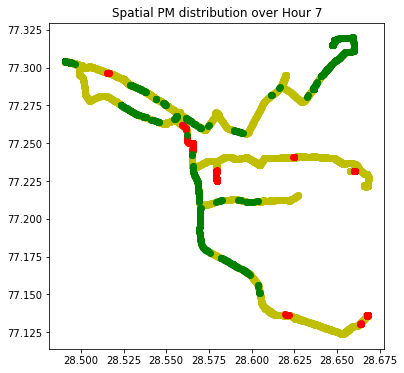

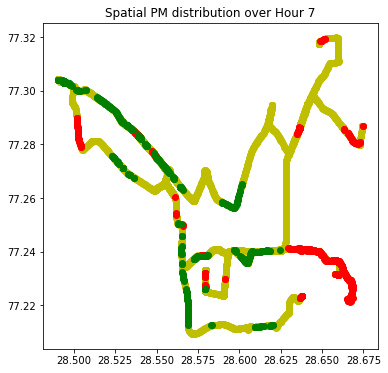

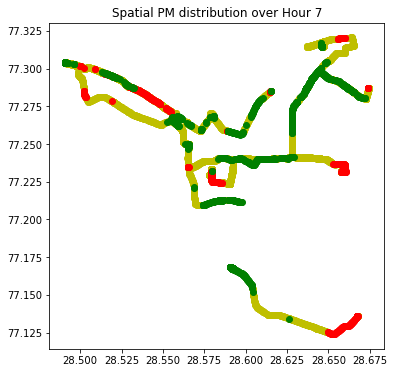

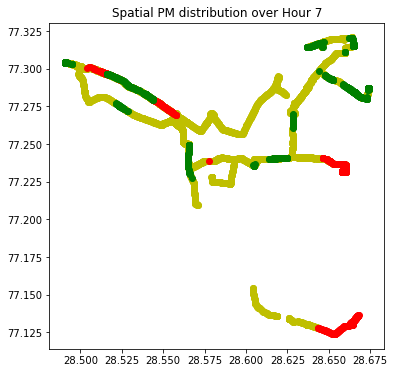

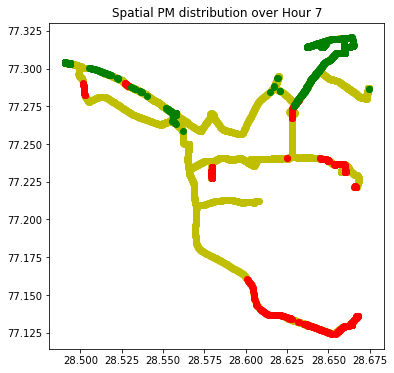

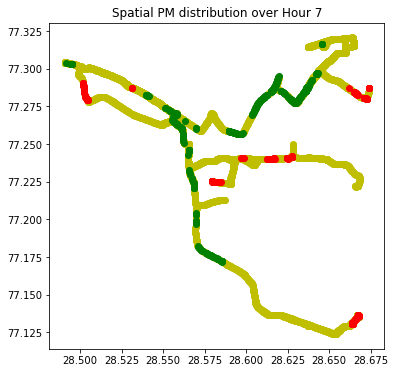

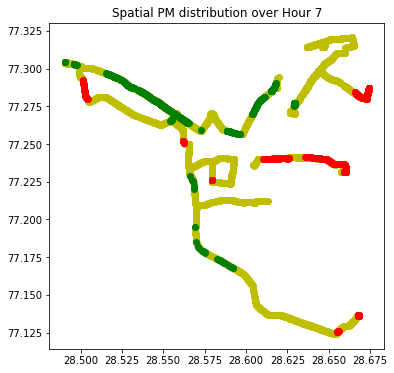

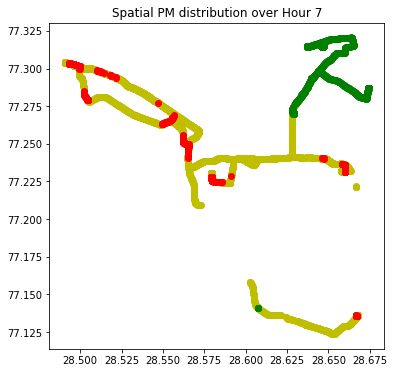

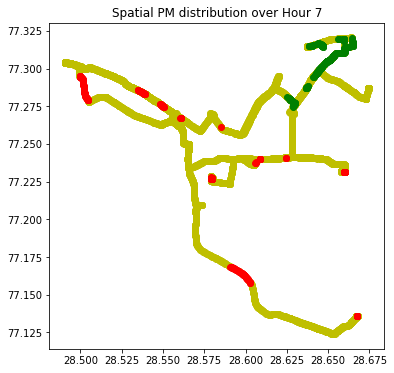

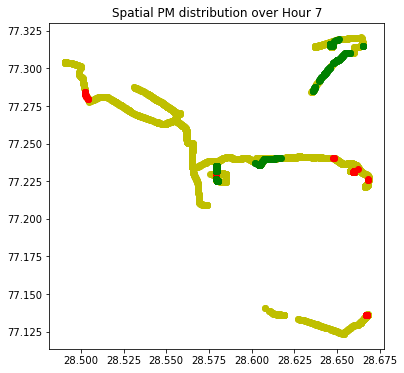

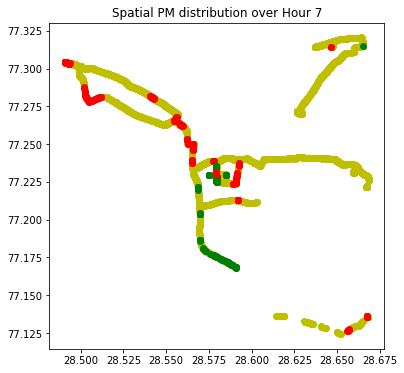

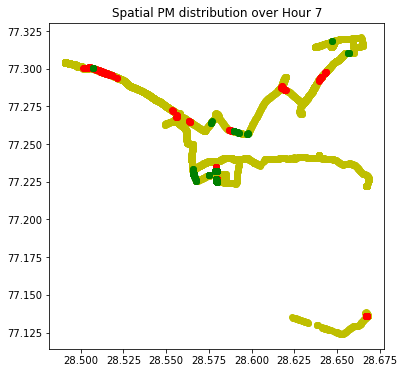

In [182]:
# plt.figure(figsize=(8, 6))
for i in range(1, 32):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    hourly_spatial(datafile, 2020, 12, i, 7)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


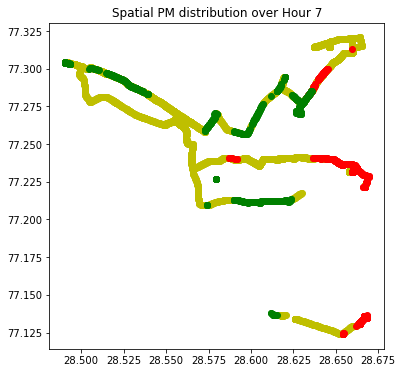

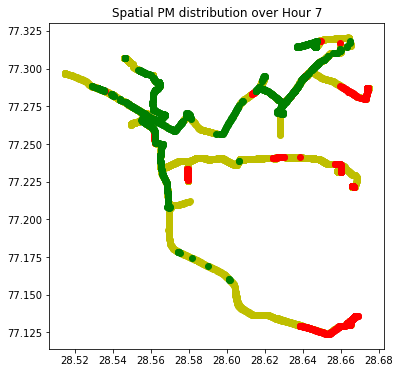

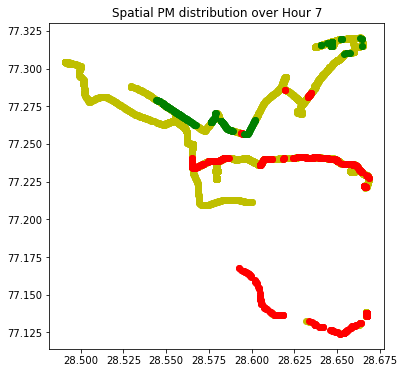

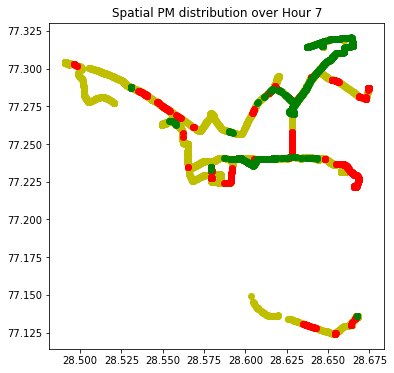

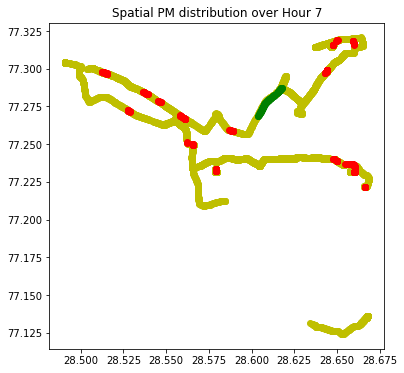

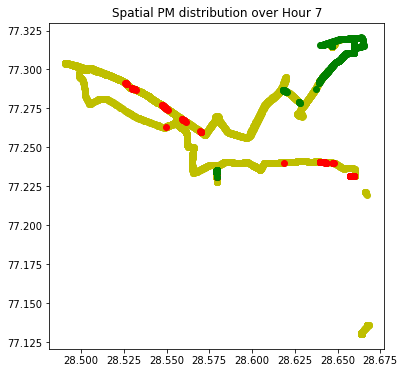

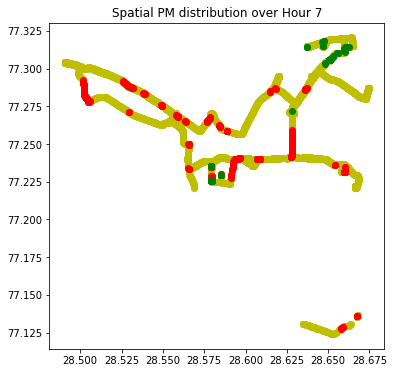

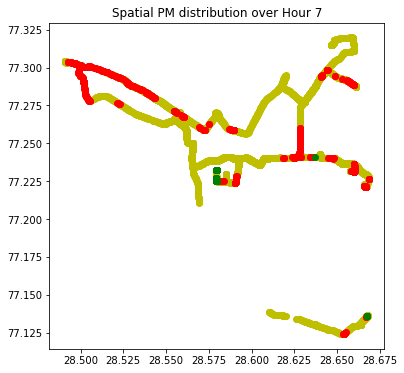

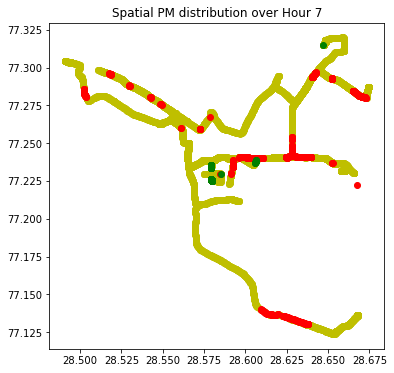

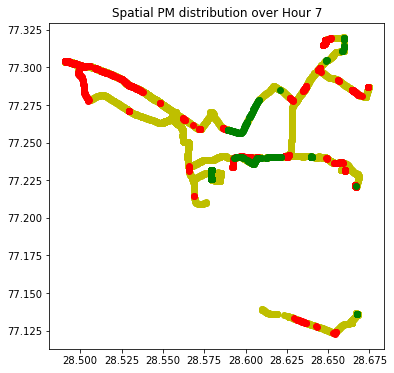

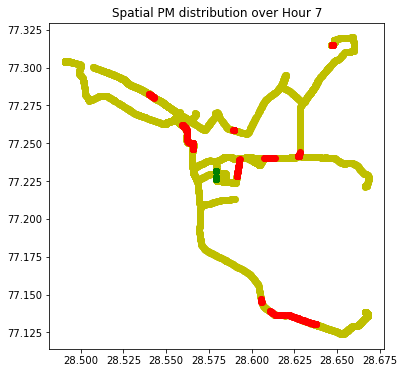

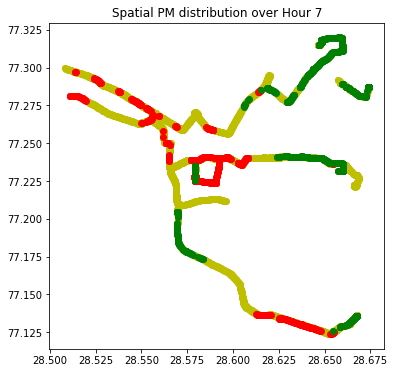

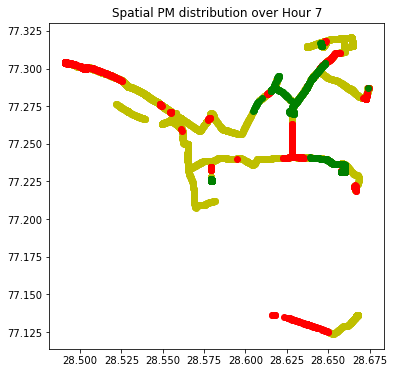

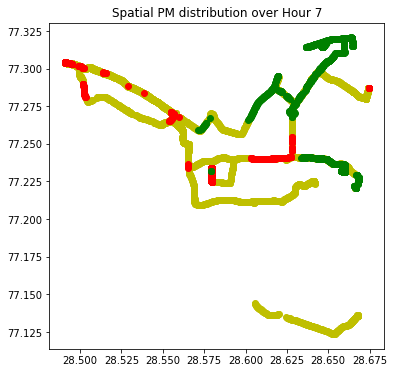

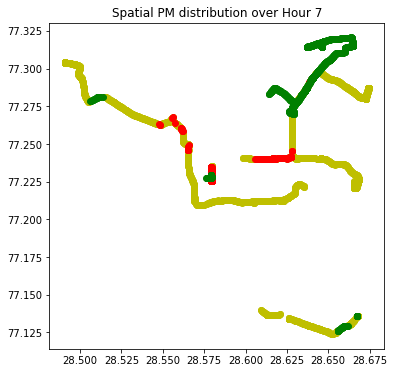

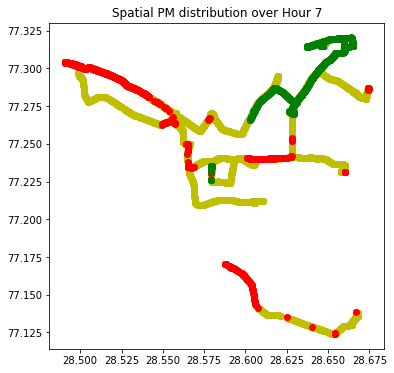

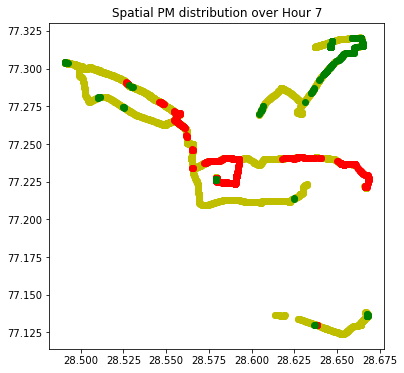

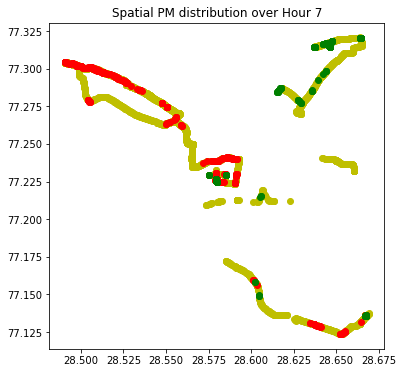

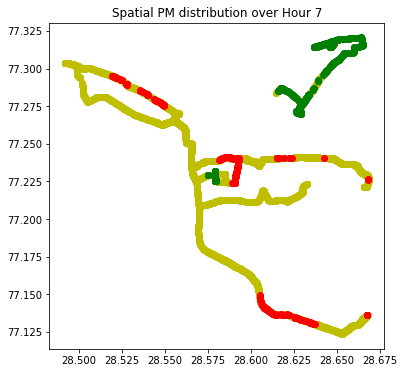

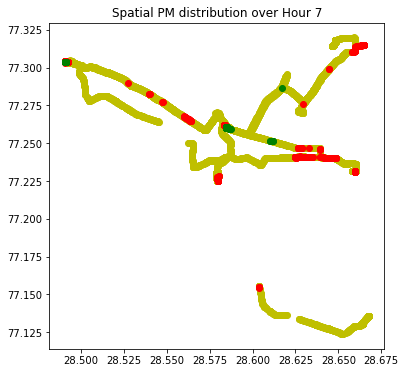

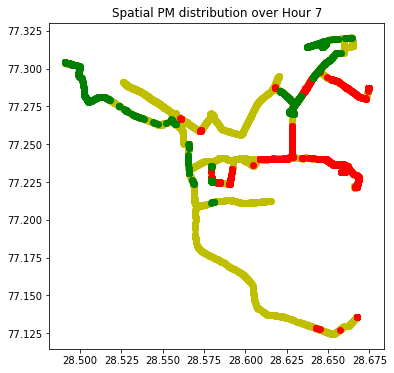

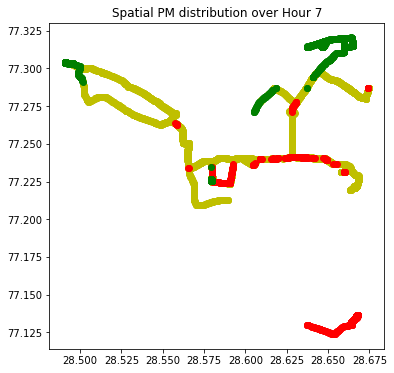

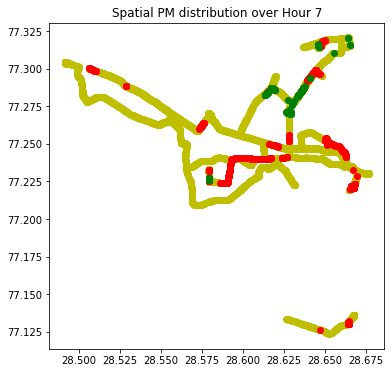

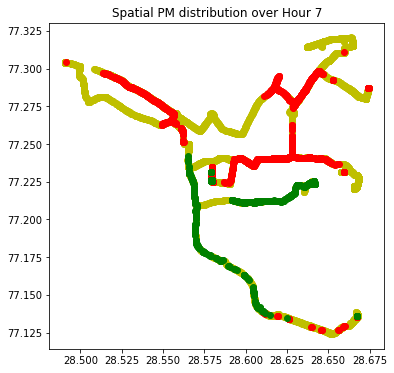

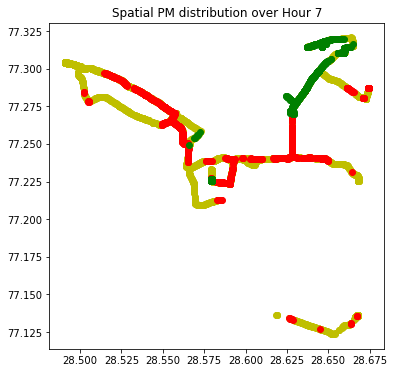

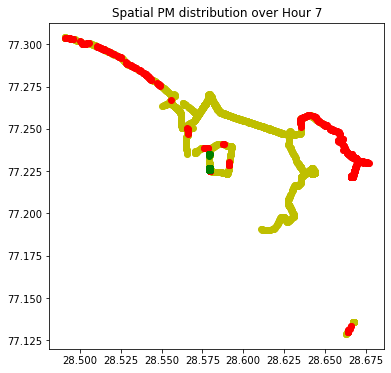

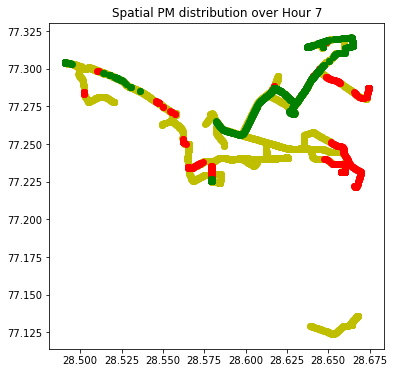

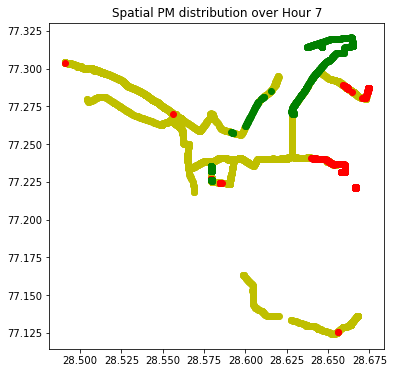

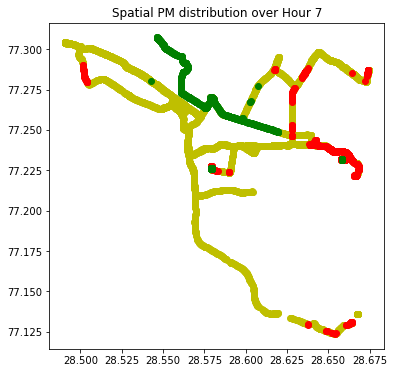

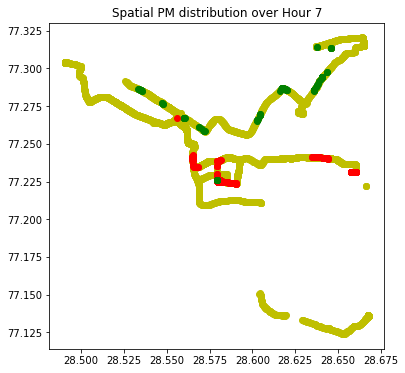

In [183]:
# plt.figure(figsize=(8, 6))
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
    hourly_spatial(datafile, 2021, 1, i, 7)

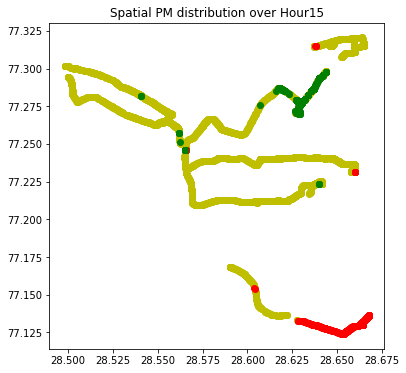

In [201]:
hourly_spatial('PM Datasets/2021-01-15_all.csv', 2021, 1, 15, 15)

## Daily spatial analysis for Hour 7

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


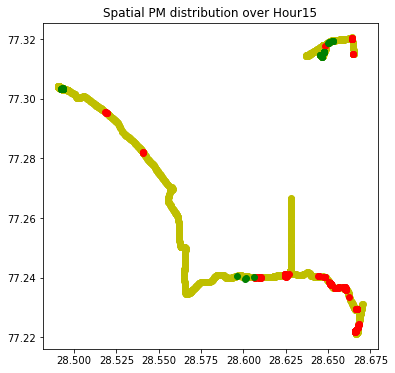

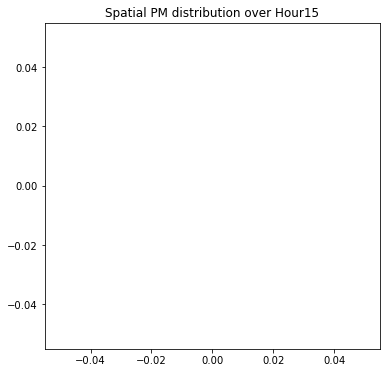

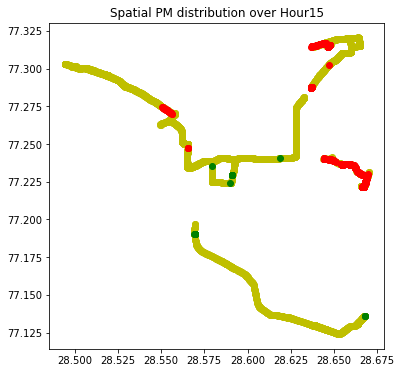

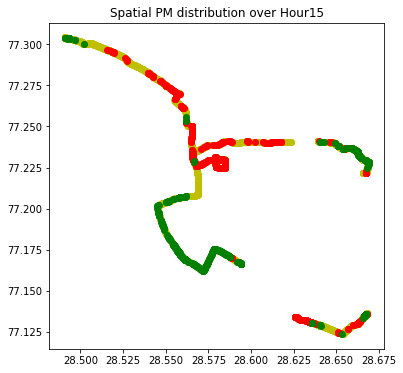

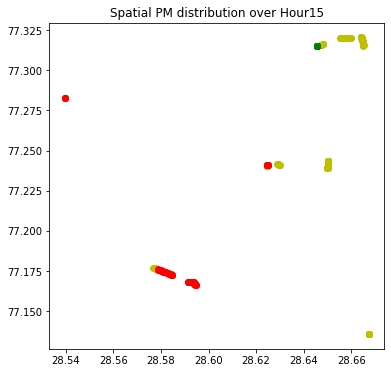

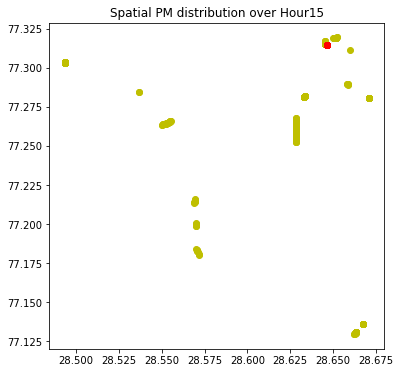

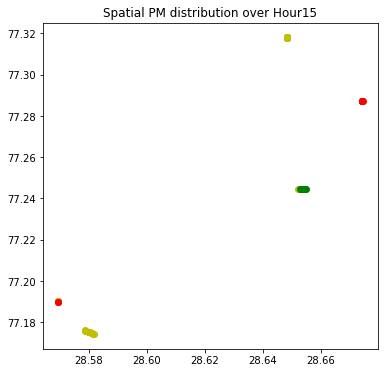

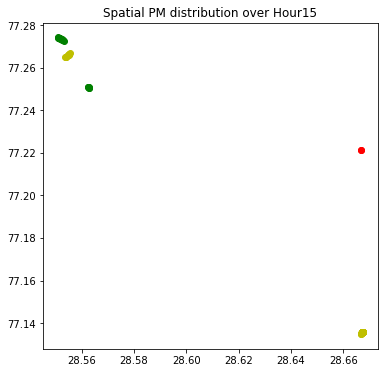

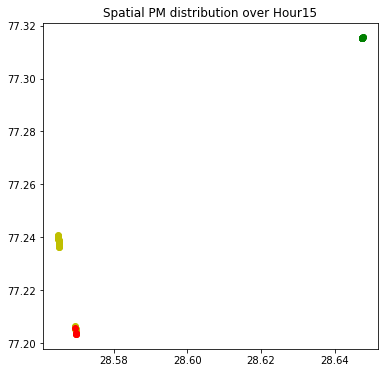

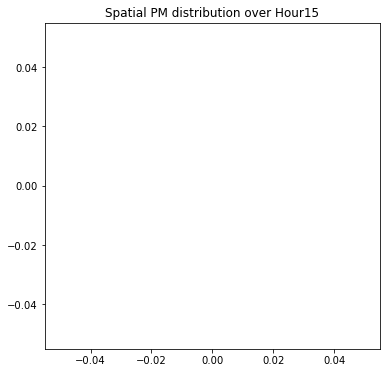

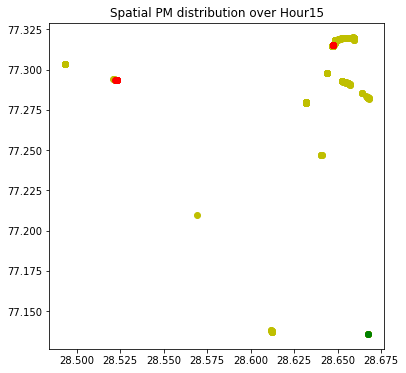

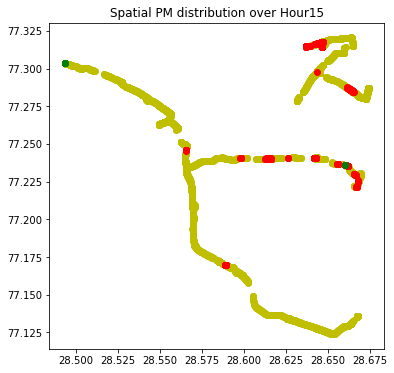

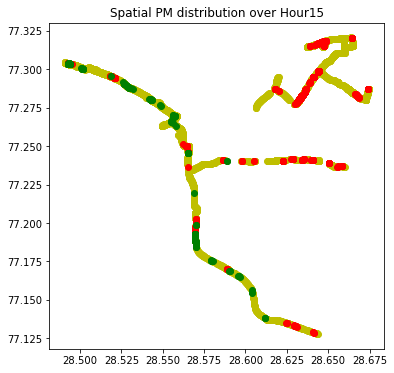

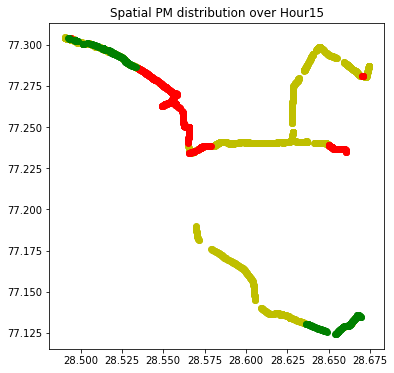

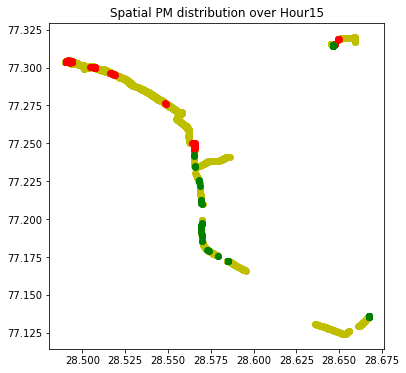

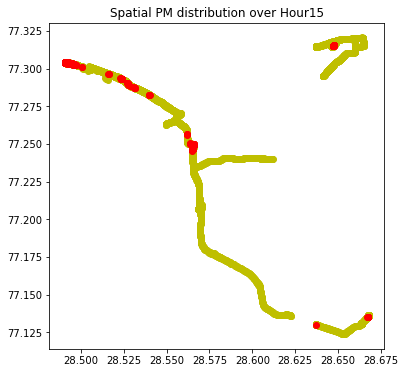

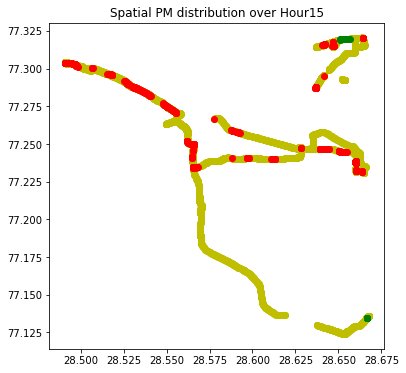

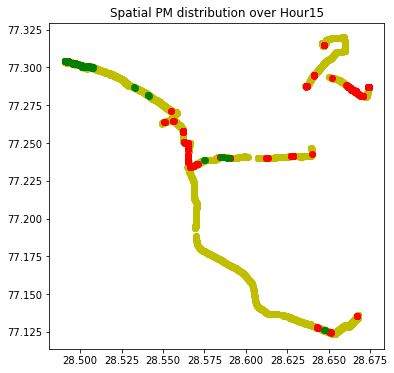

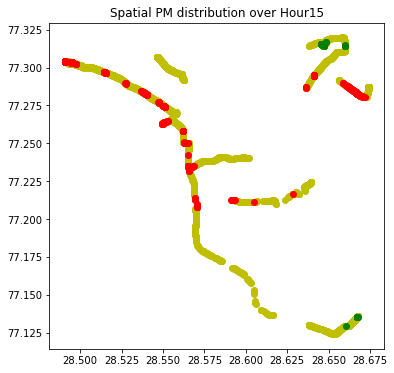

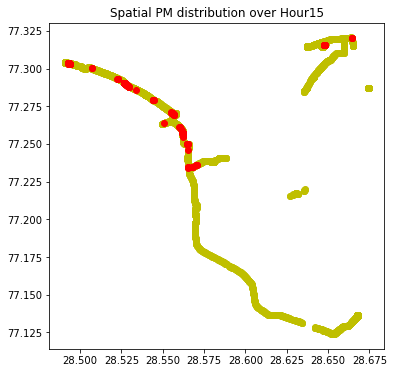

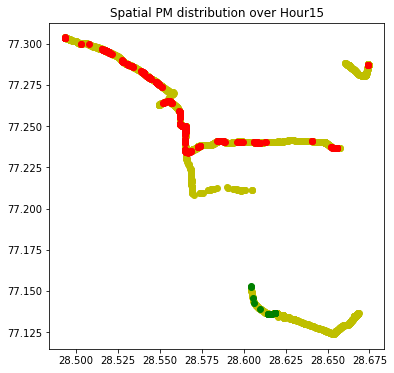

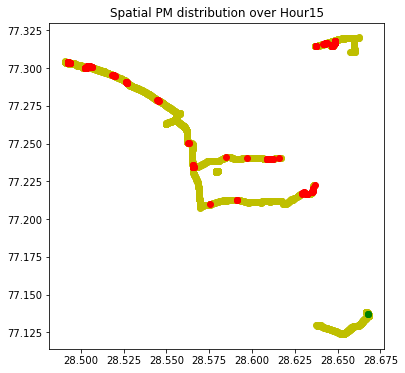

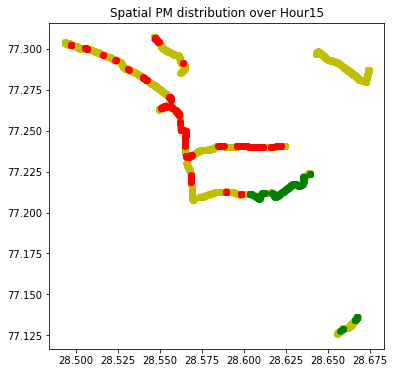

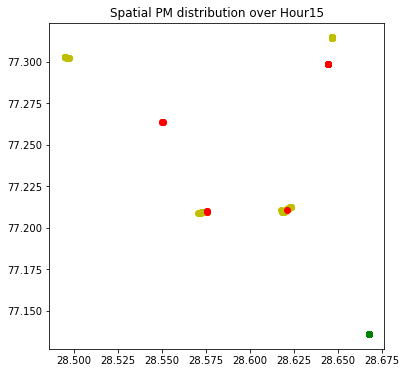

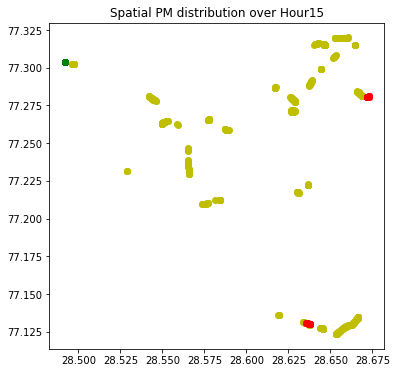

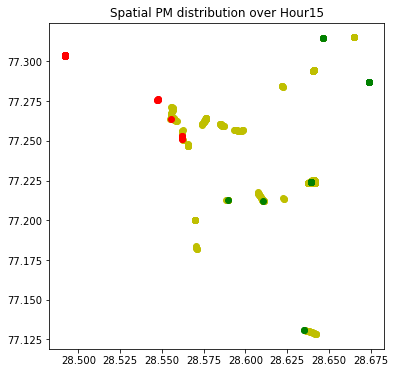

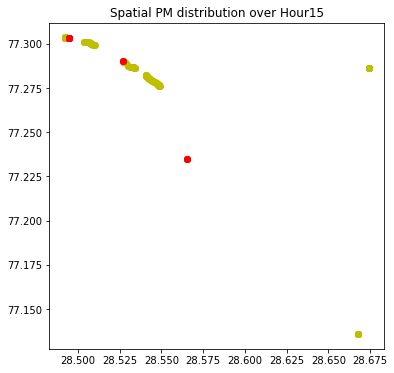

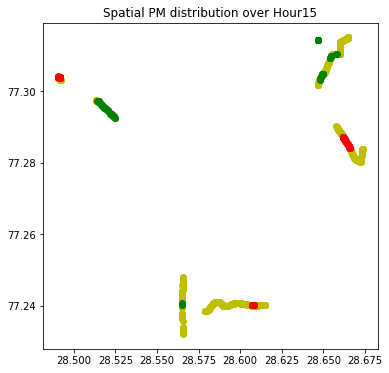

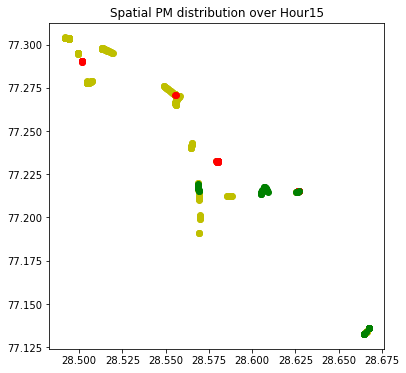

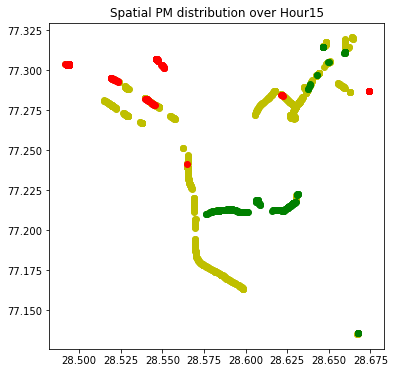

In [203]:
# plt.figure(figsize=(8, 6))
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    hourly_spatial(datafile, 2020, 11, i, 15)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


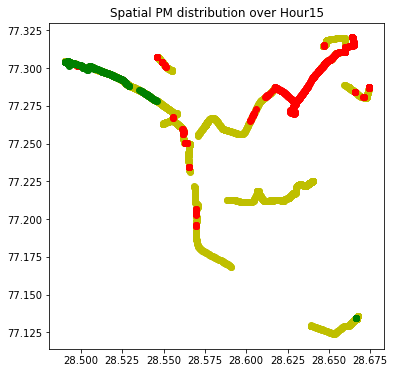

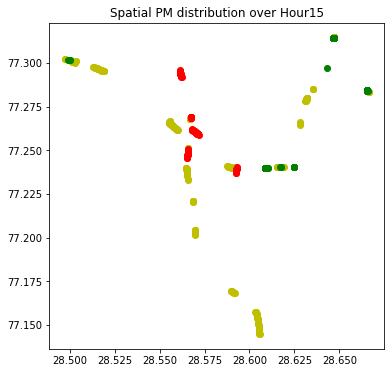

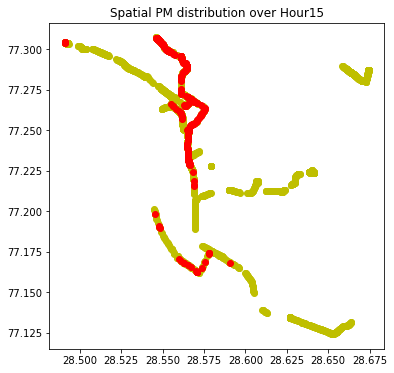

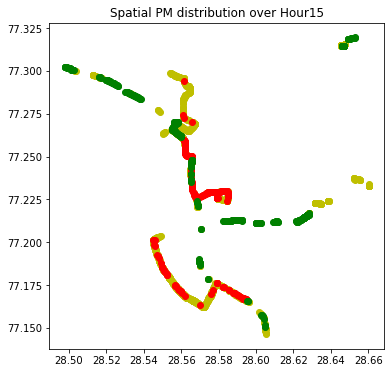

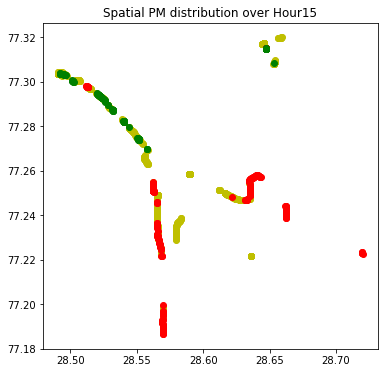

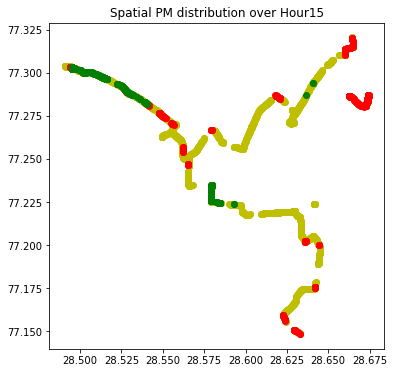

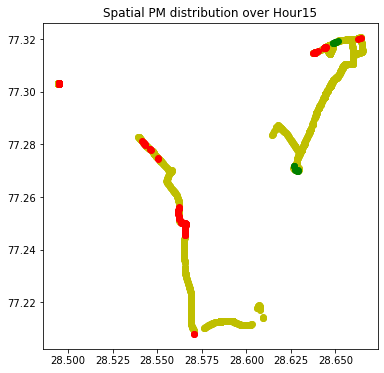

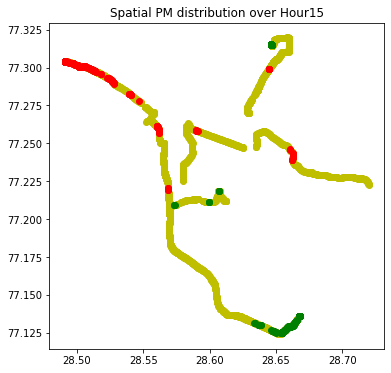

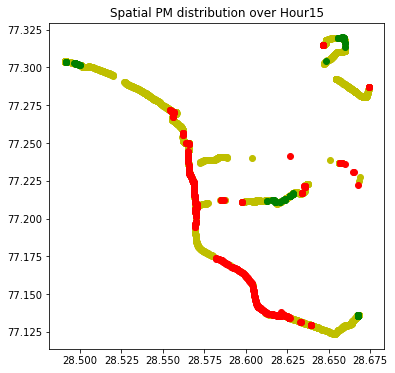

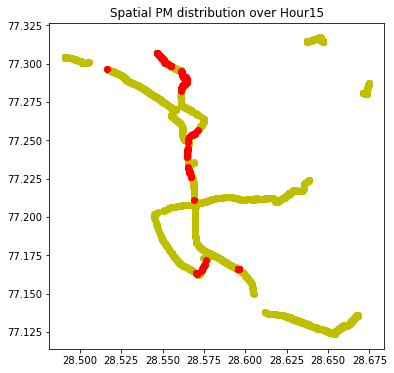

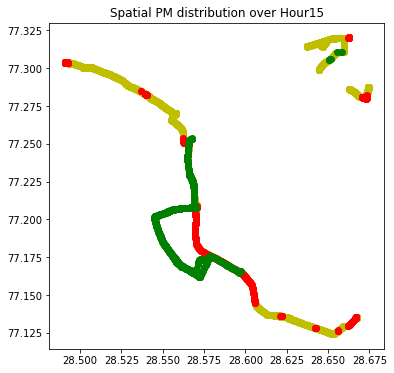

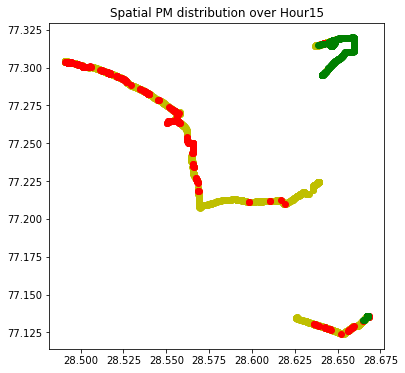

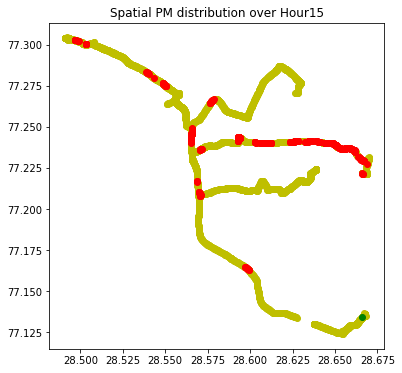

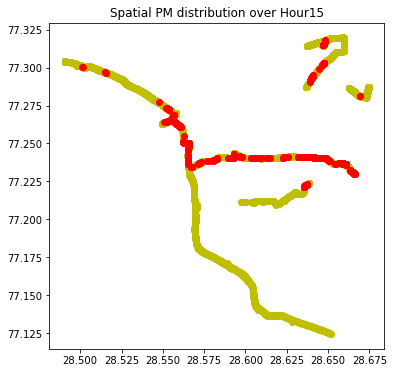

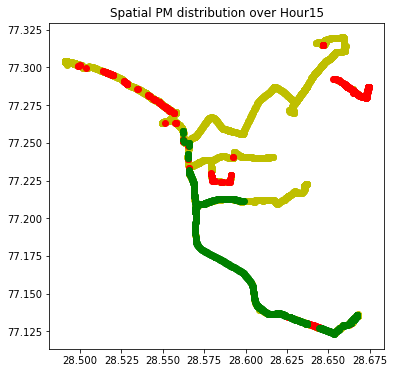

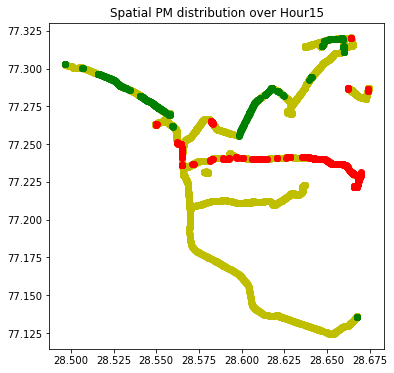

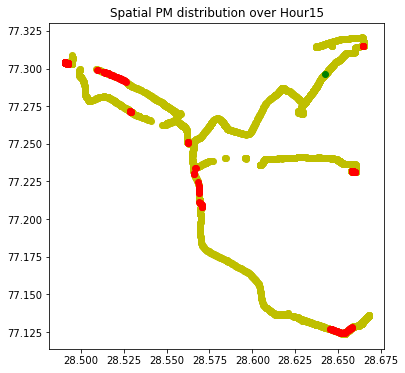

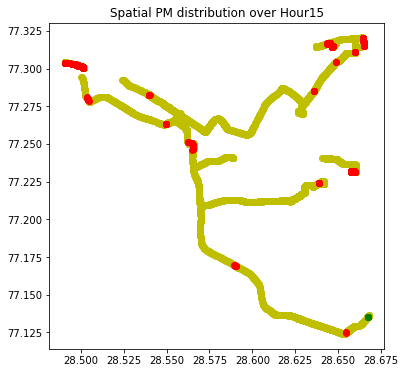

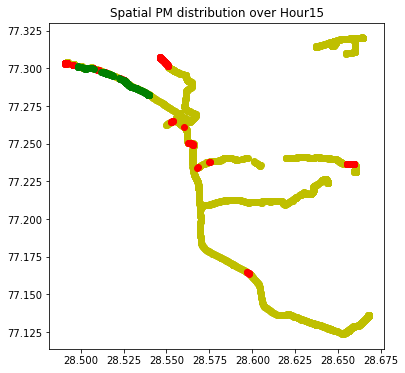

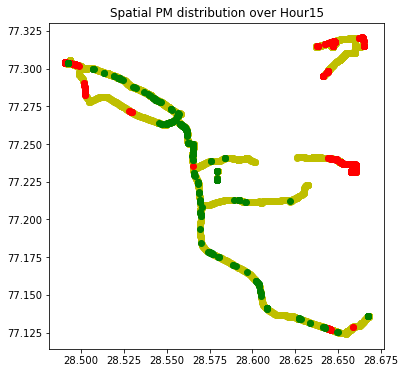

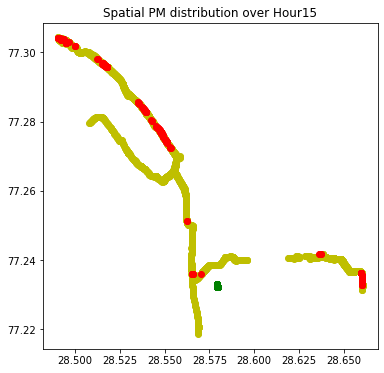

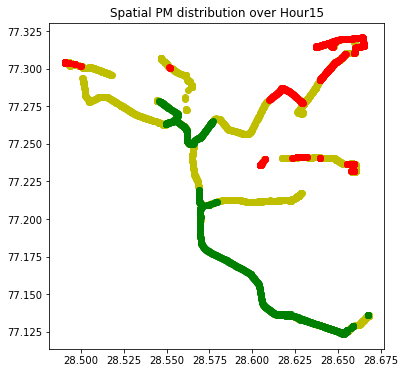

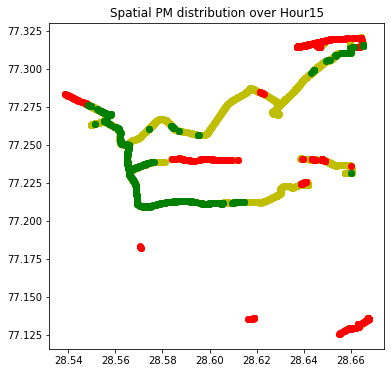

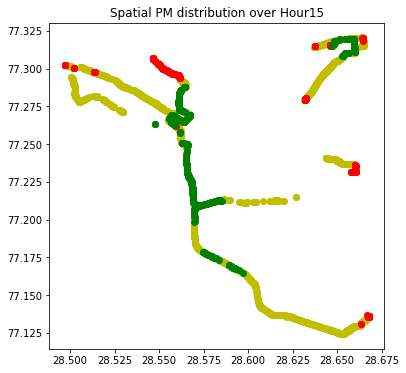

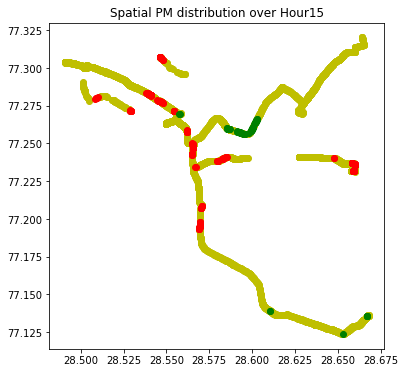

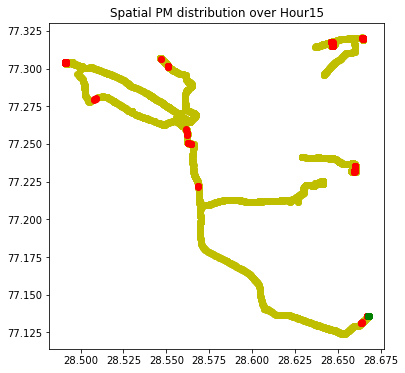

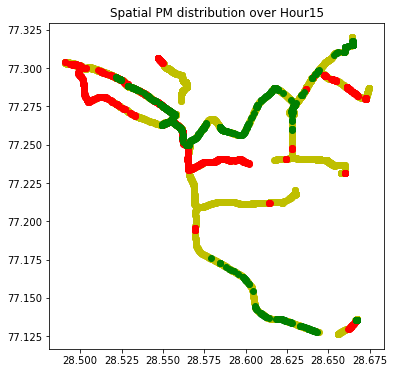

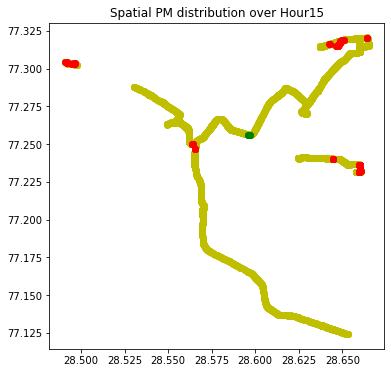

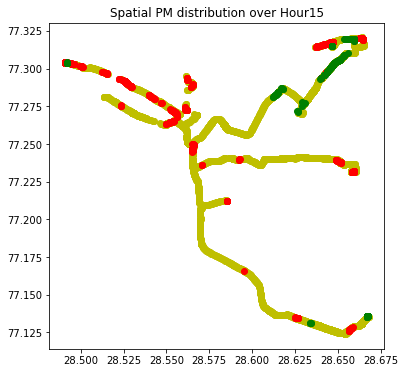

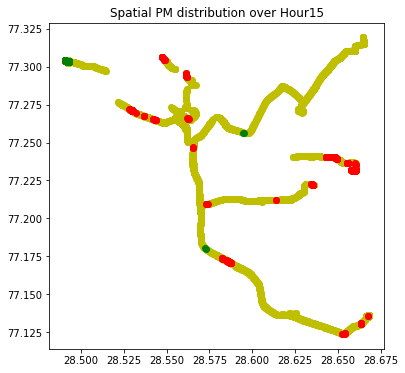

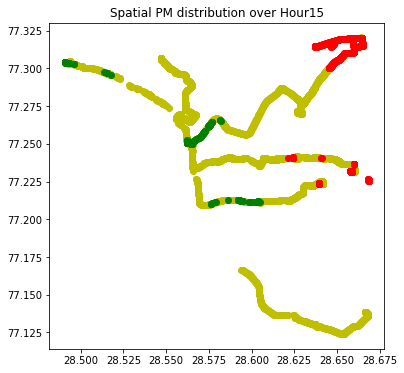

In [204]:
# plt.figure(figsize=(8, 6))
for i in range(1, 32):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    hourly_spatial(datafile, 2020, 12, i, 15)

## Daily spatial analysis for Hour 21

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


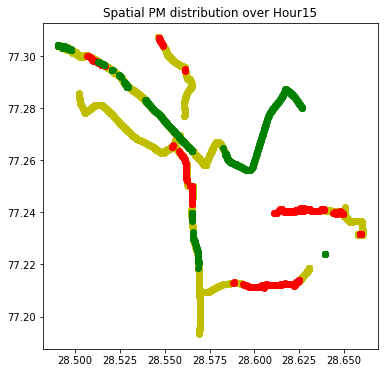

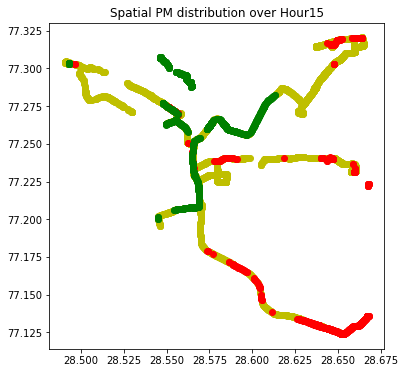

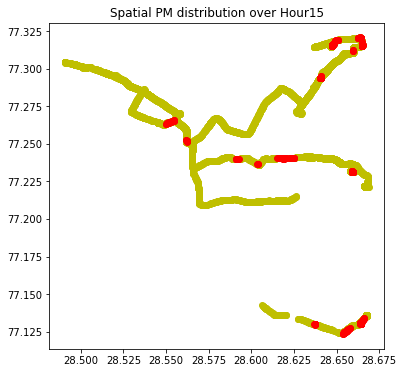

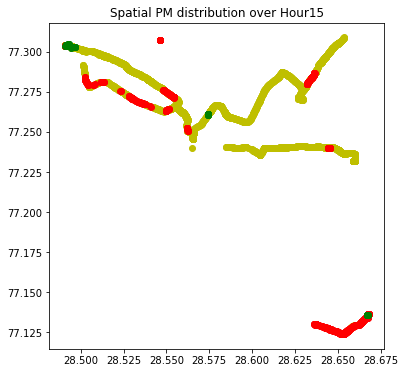

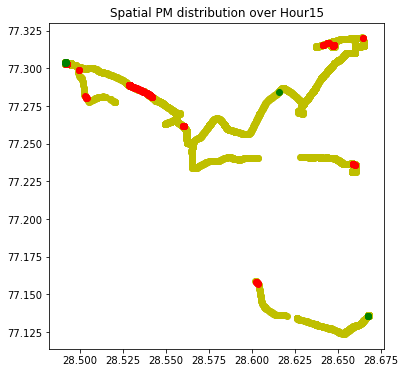

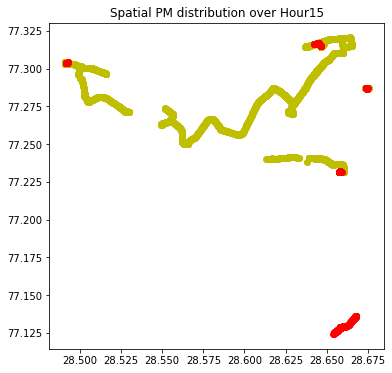

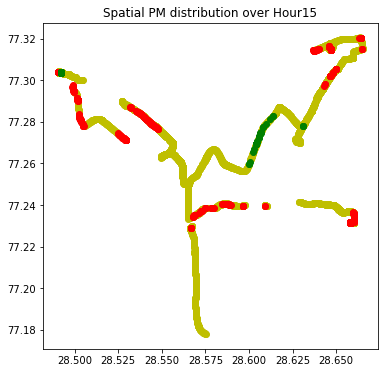

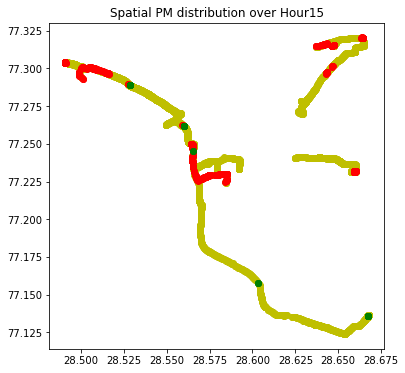

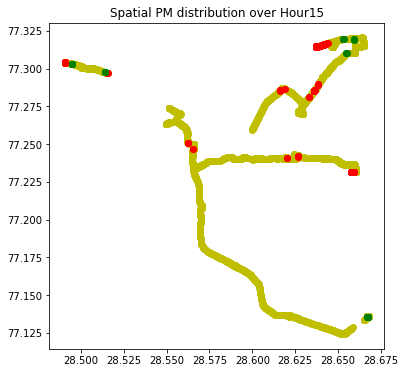

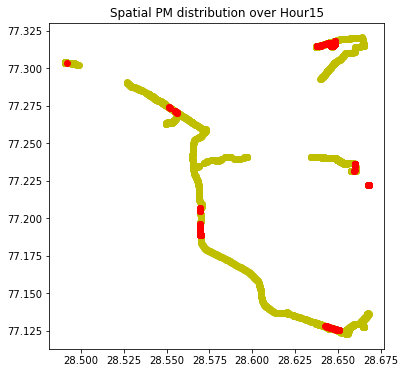

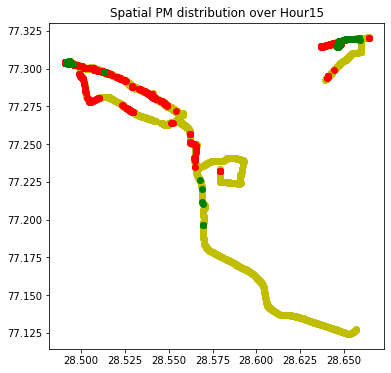

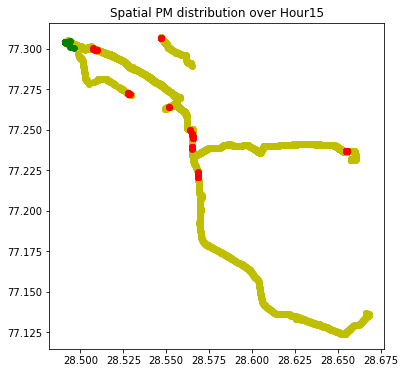

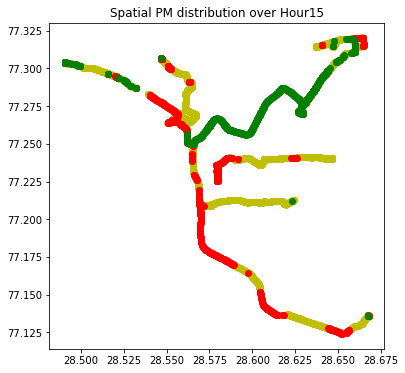

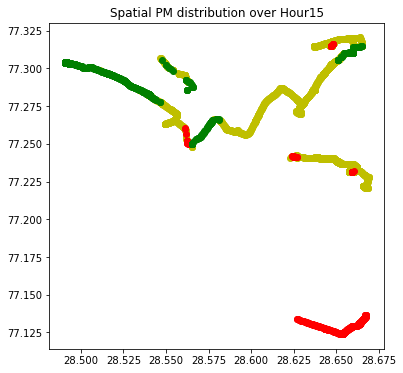

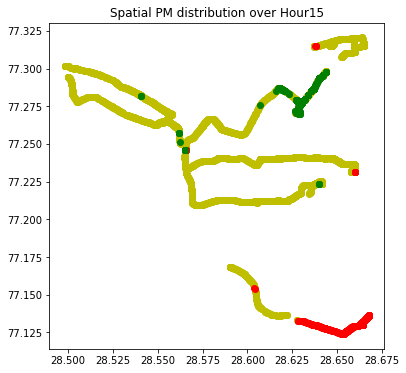

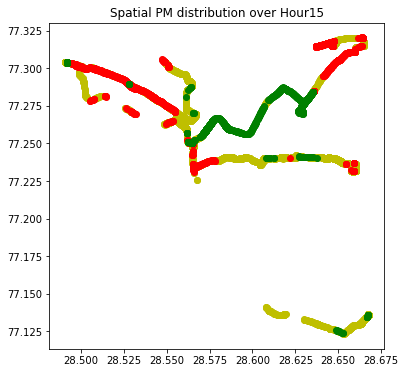

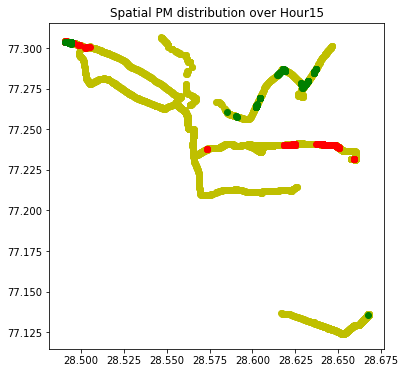

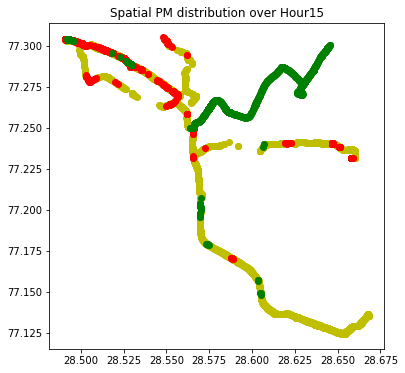

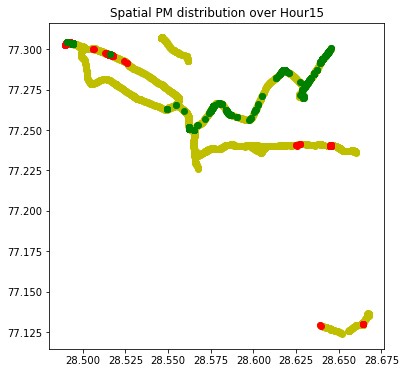

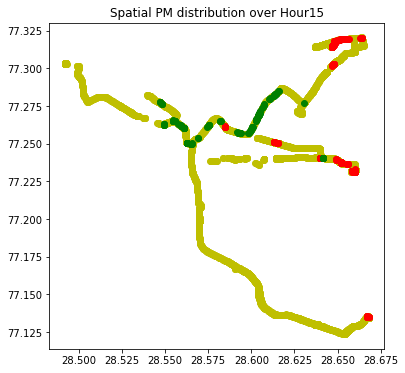

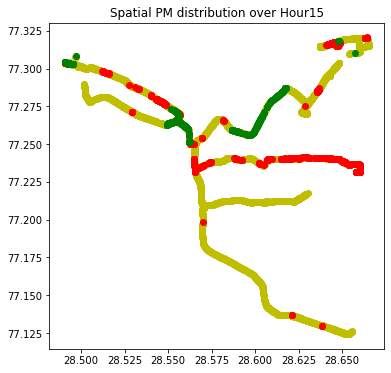

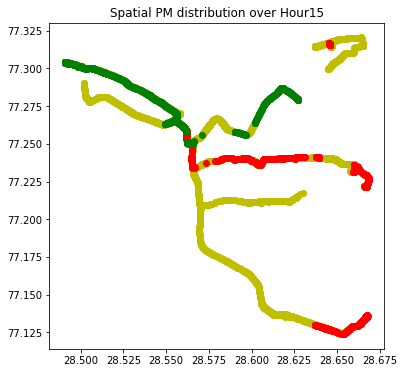

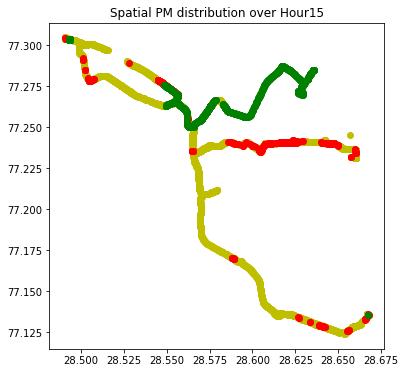

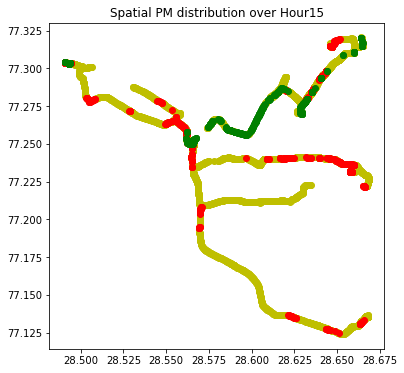

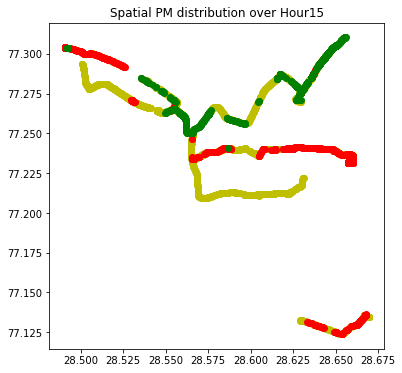

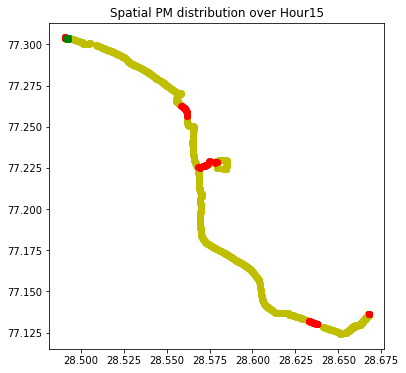

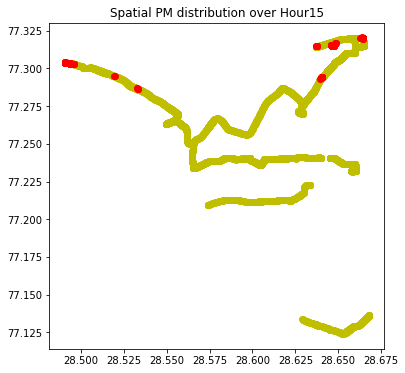

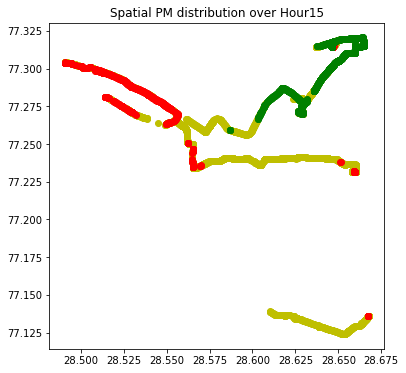

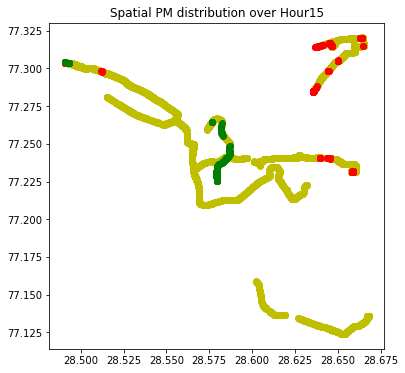

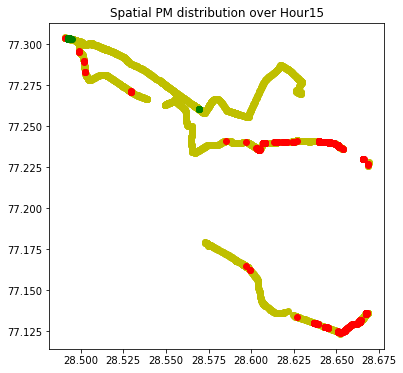

In [205]:
# plt.figure(figsize=(8, 6))
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
    hourly_spatial(datafile, 2021, 1, i, 21)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


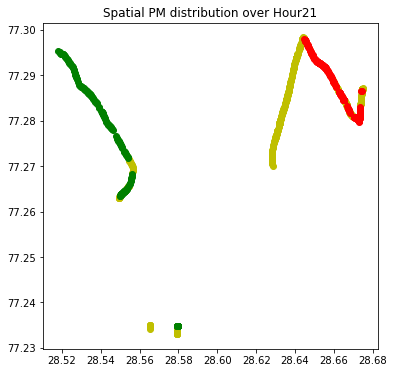

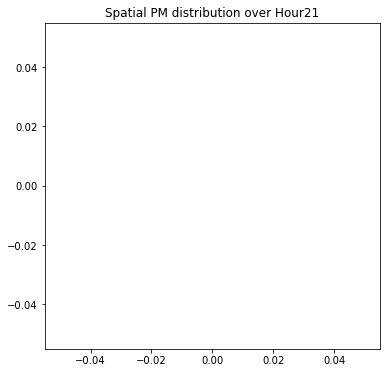

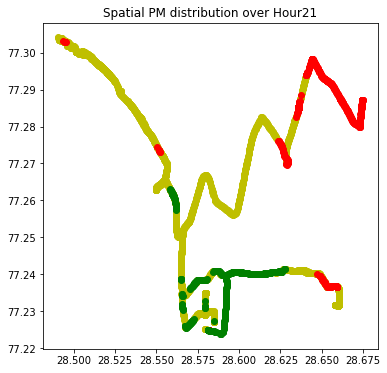

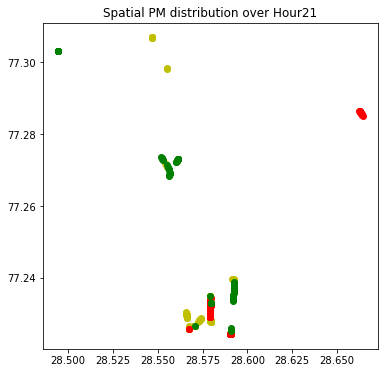

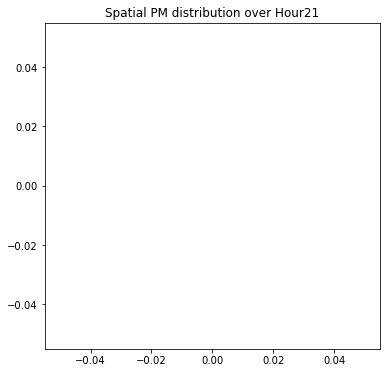

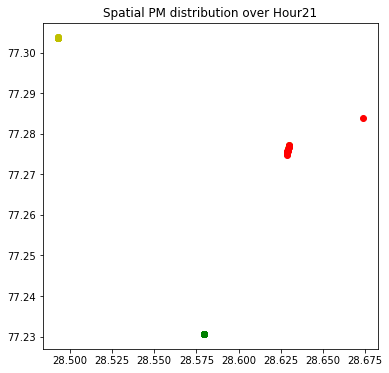

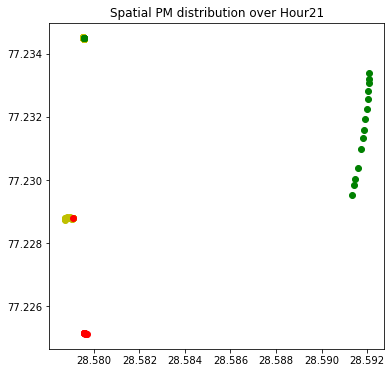

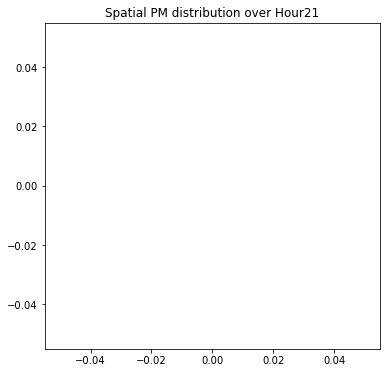

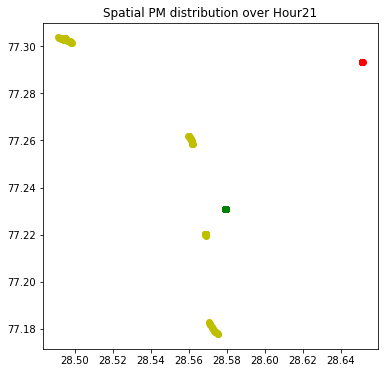

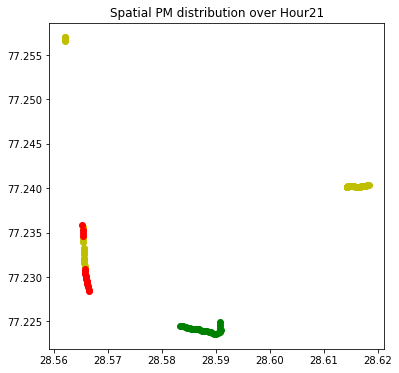

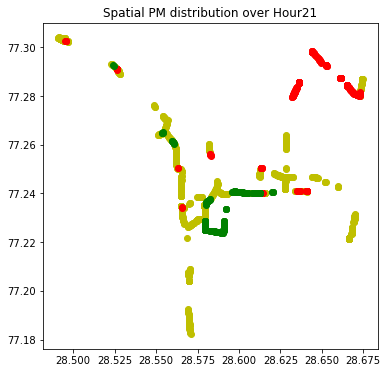

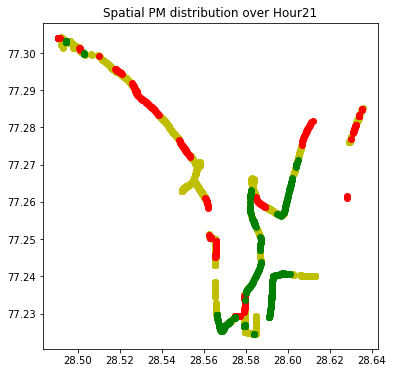

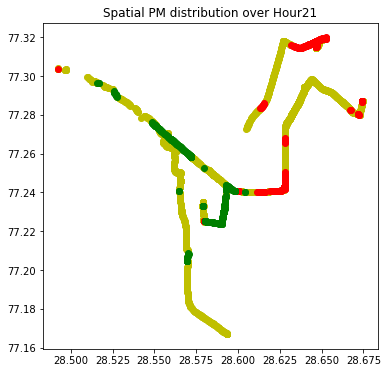

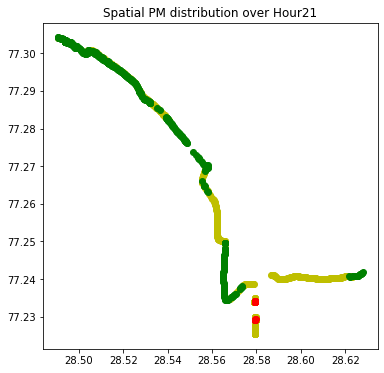

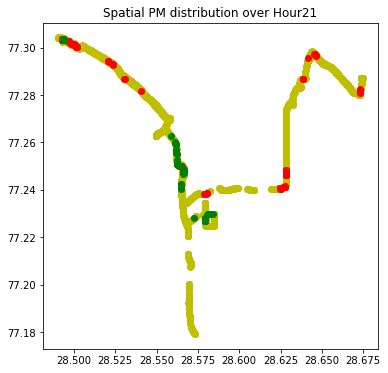

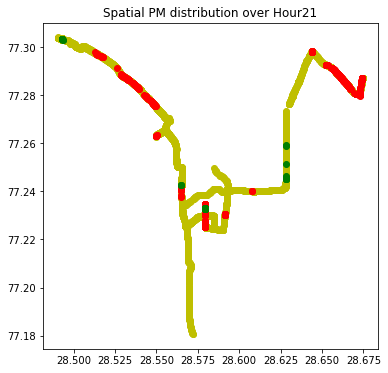

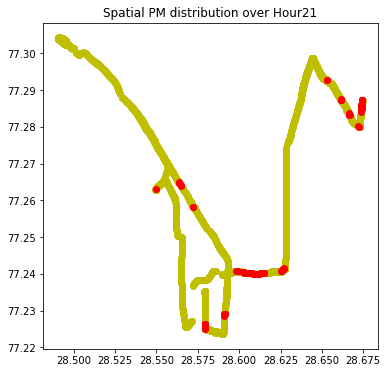

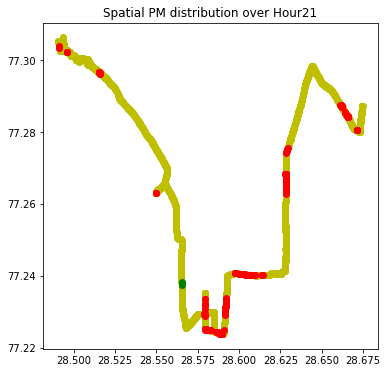

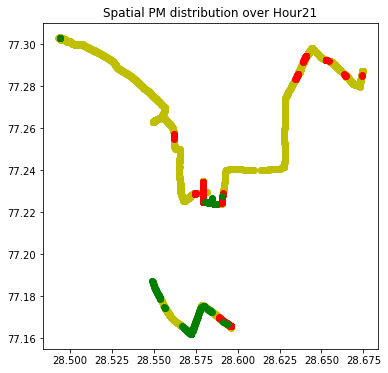

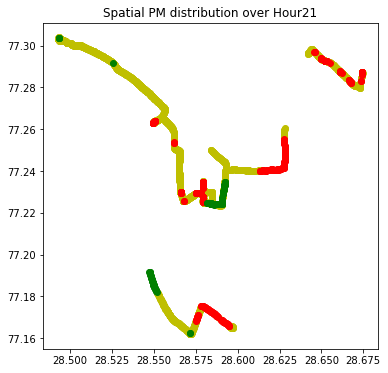

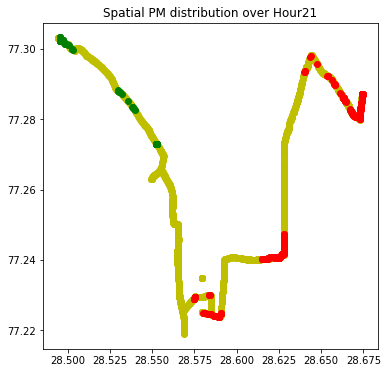

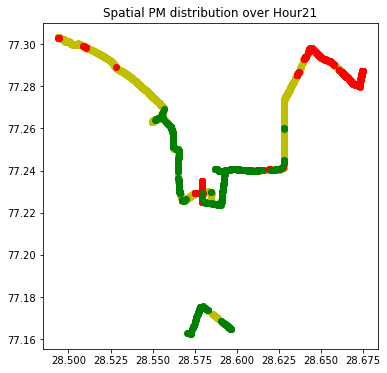

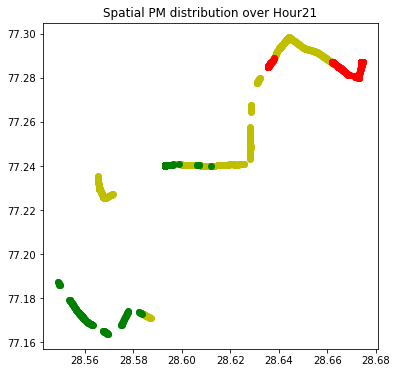

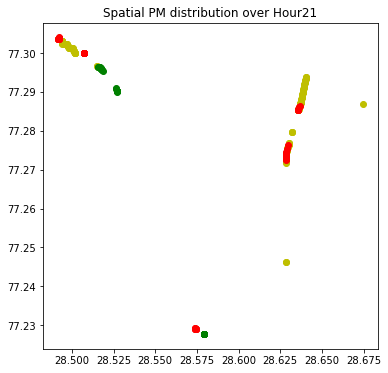

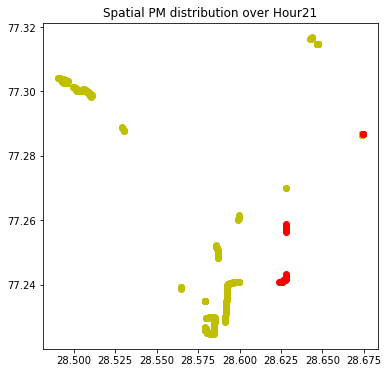

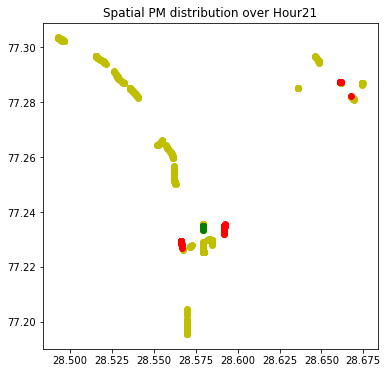

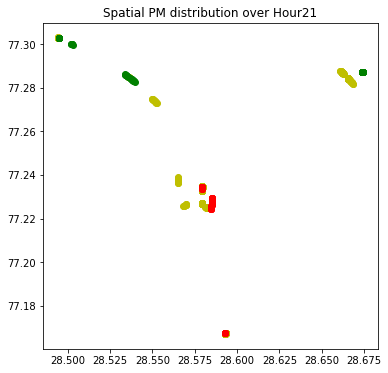

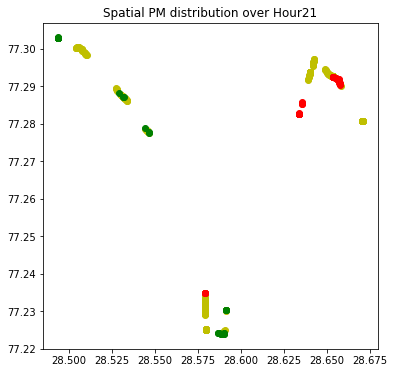

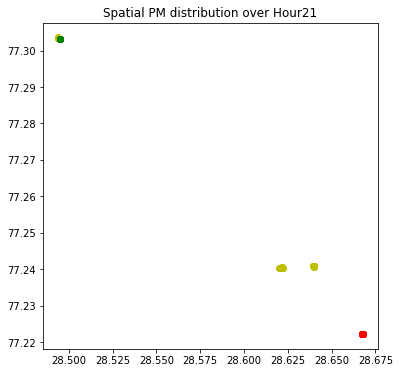

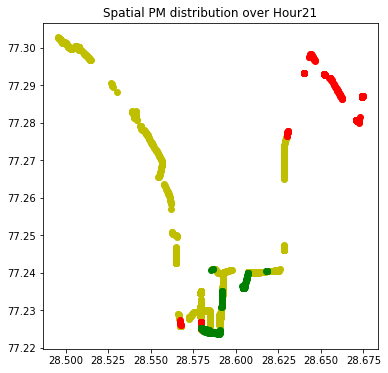

In [206]:
# plt.figure(figsize=(8, 6))
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-11-' + str(i) + '_all.csv'
    hourly_spatial(datafile, 2020, 11, i, 21)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


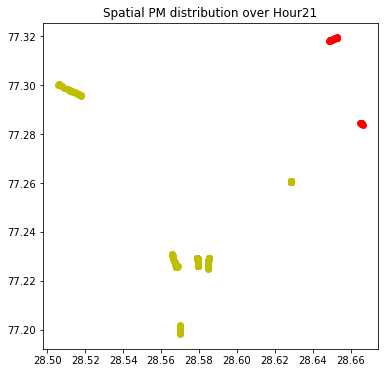

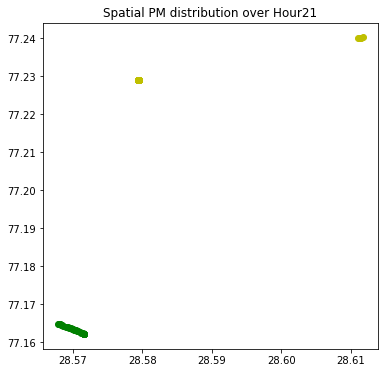

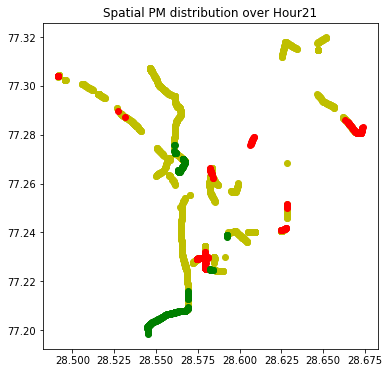

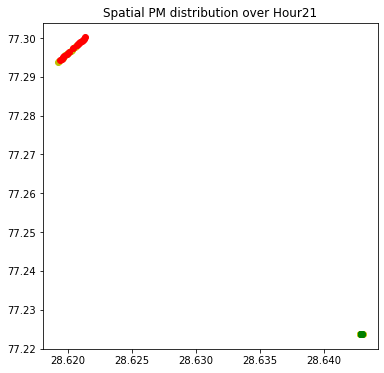

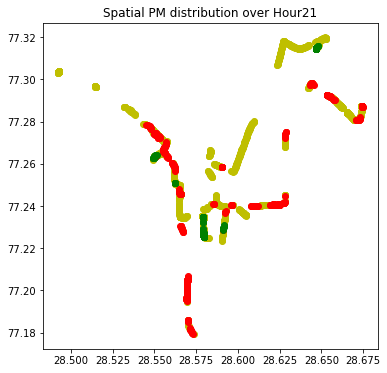

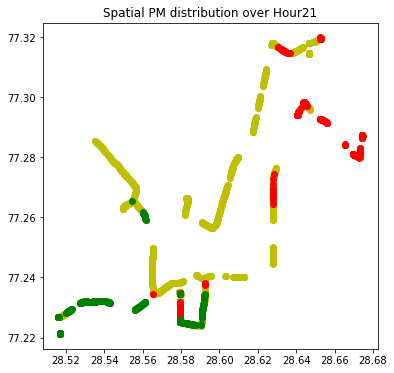

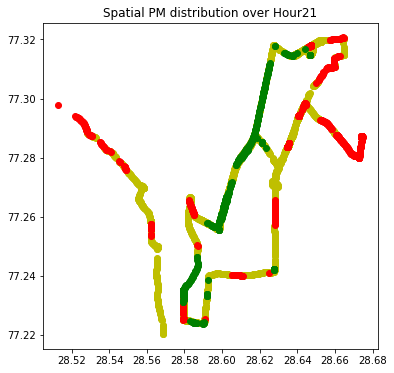

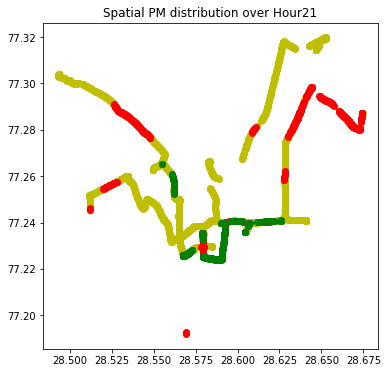

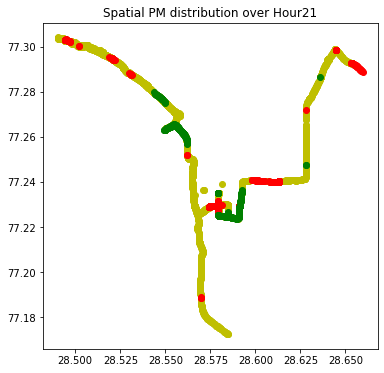

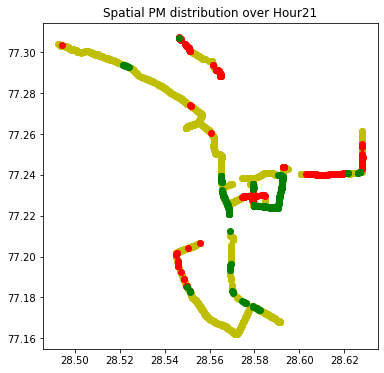

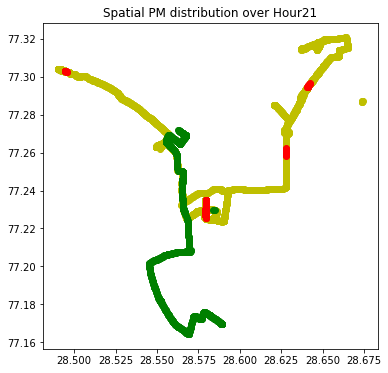

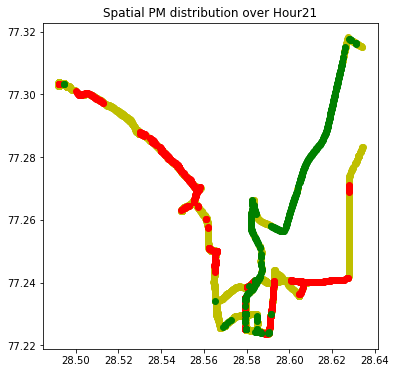

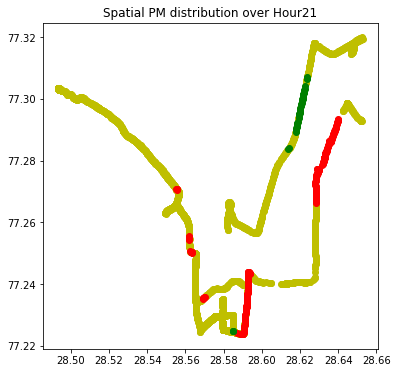

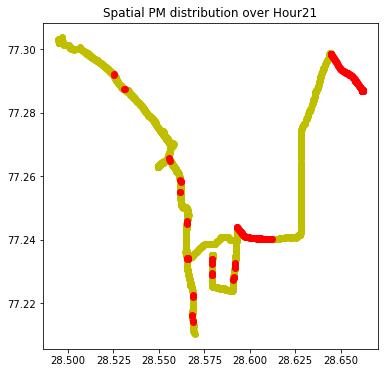

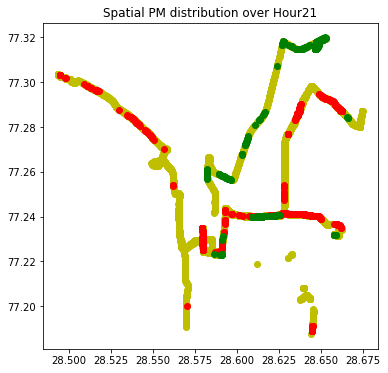

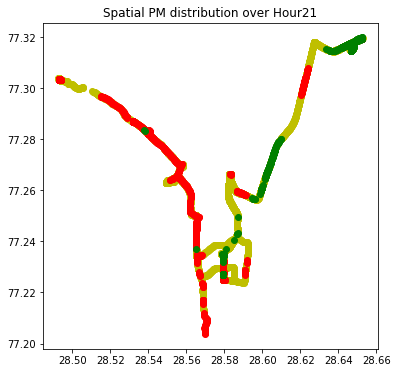

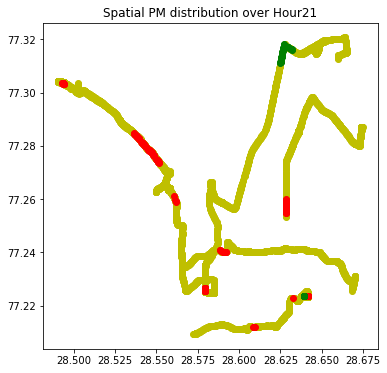

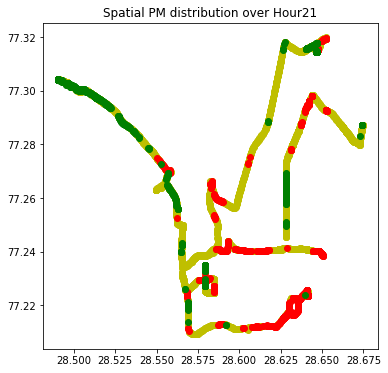

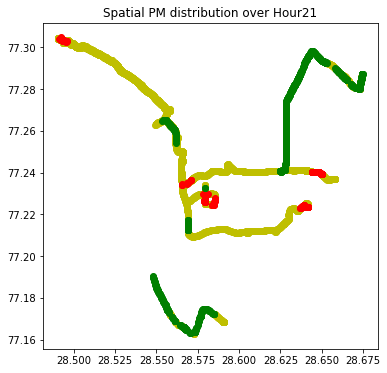

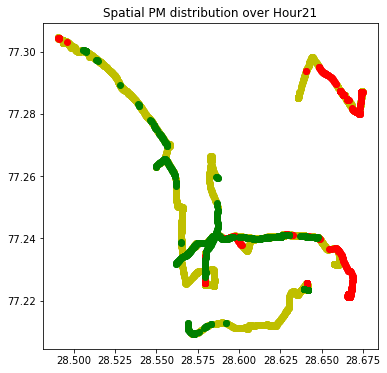

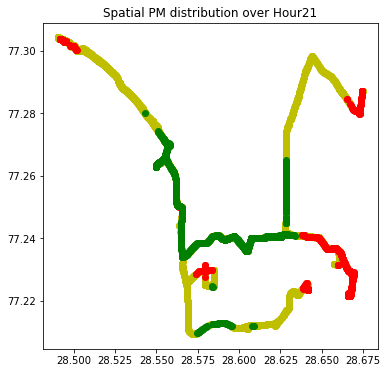

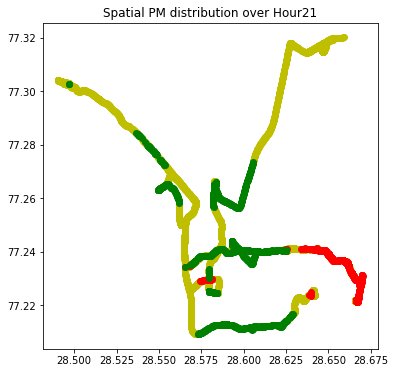

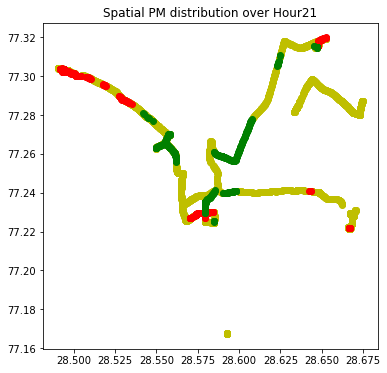

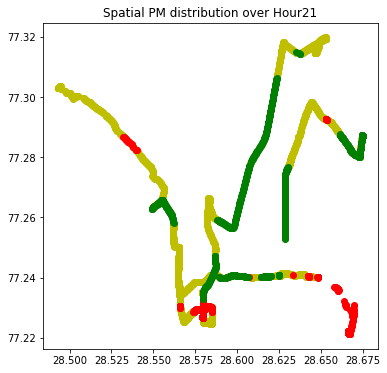

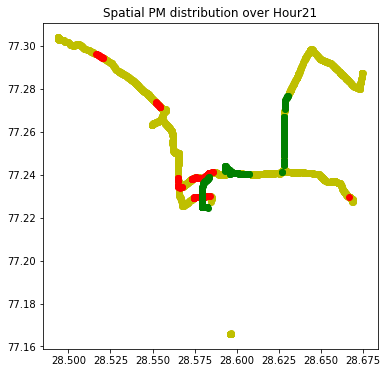

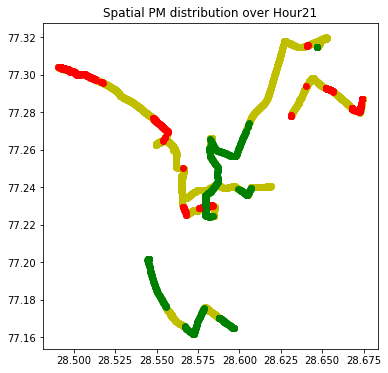

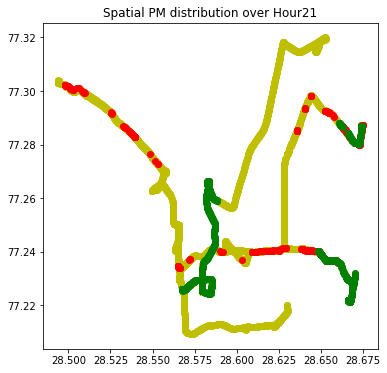

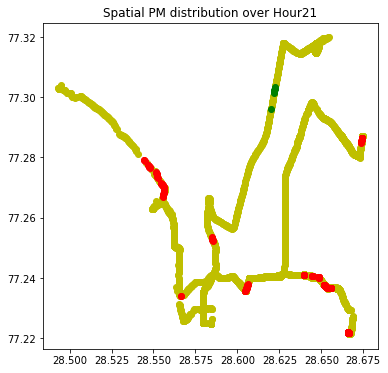

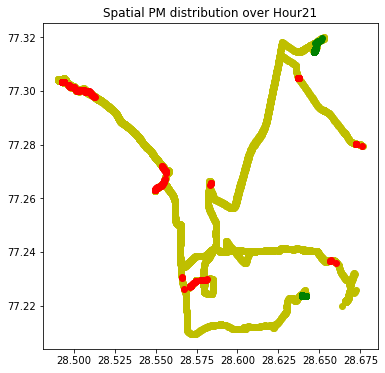

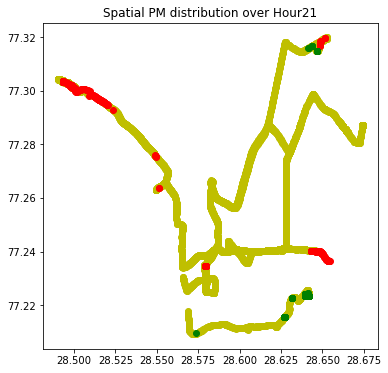

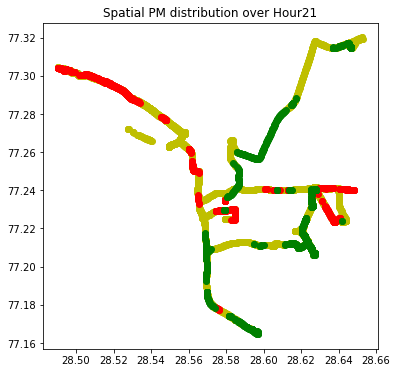

In [207]:
# plt.figure(figsize=(8, 6))
for i in range(1, 32):
    if i<10:
        datafile = 'PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2020-12-' + str(i) + '_all.csv'
    hourly_spatial(datafile, 2020, 12, i, 21)

/home/gauri/anaconda3/envs/crypten/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


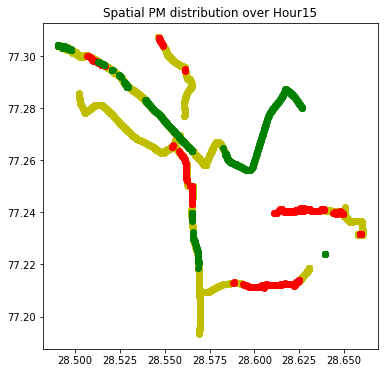

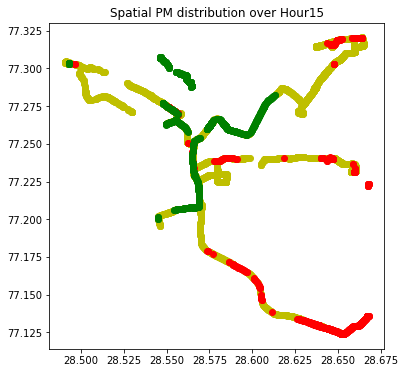

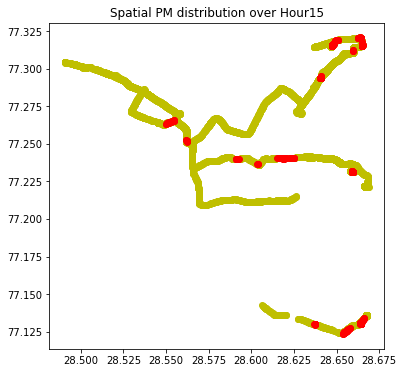

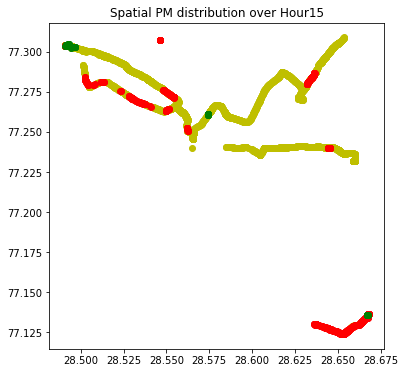

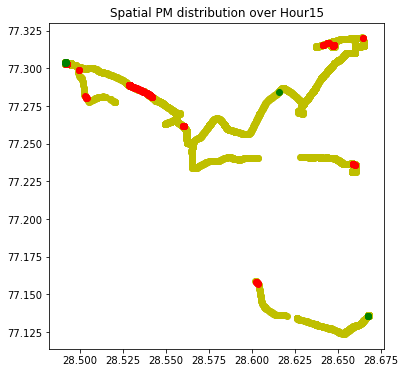

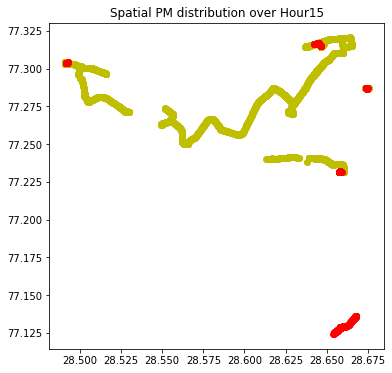

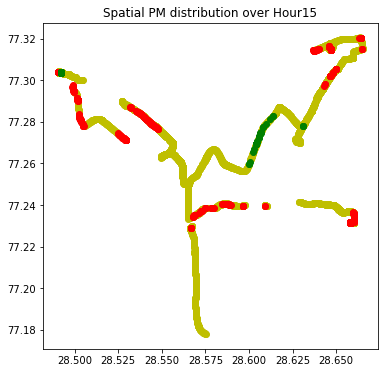

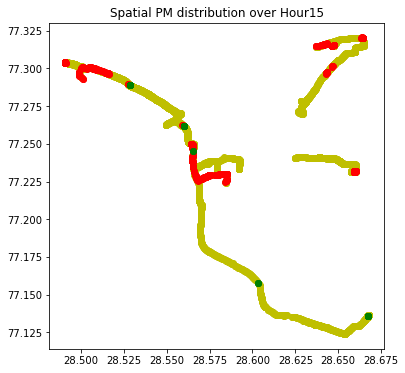

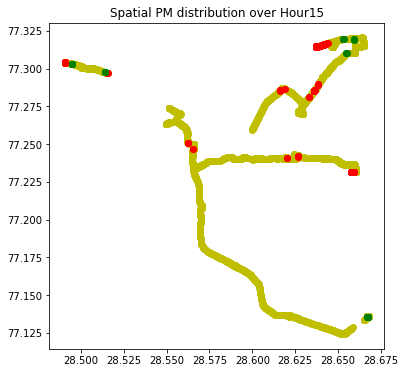

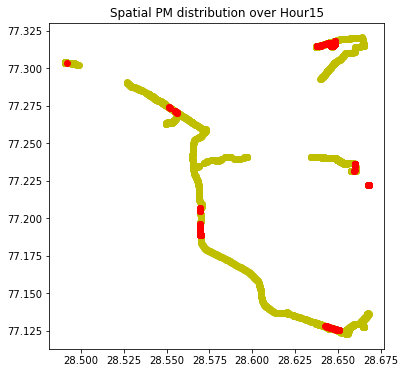

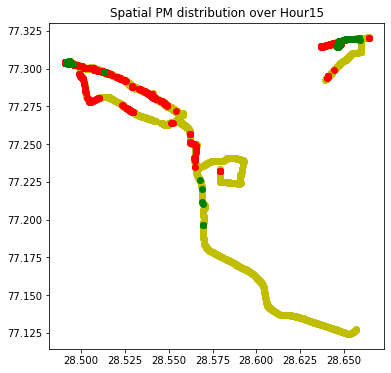

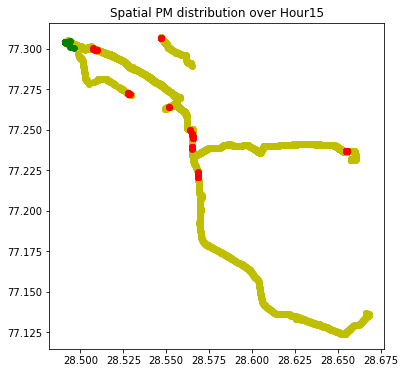

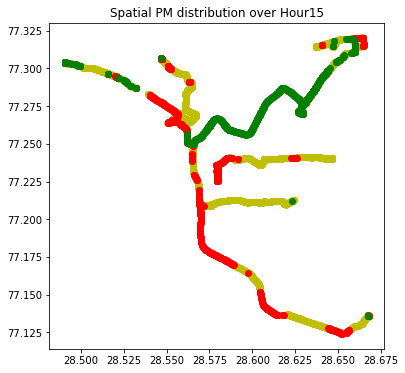

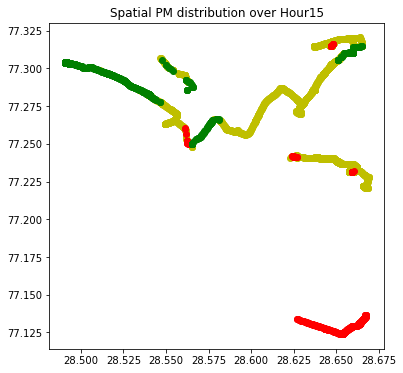

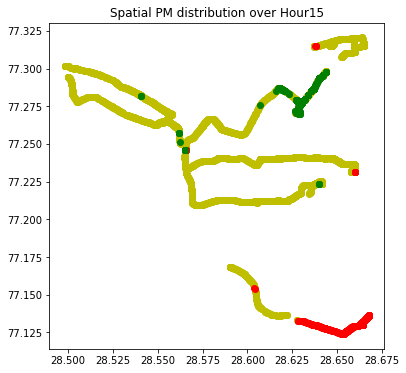

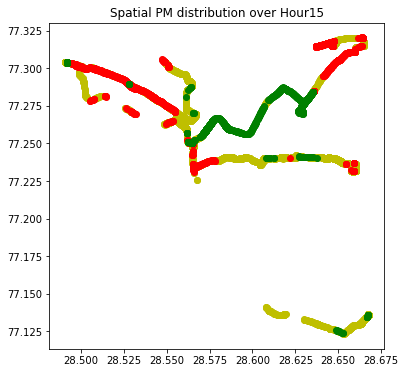

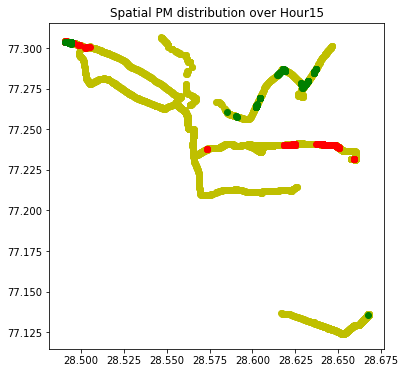

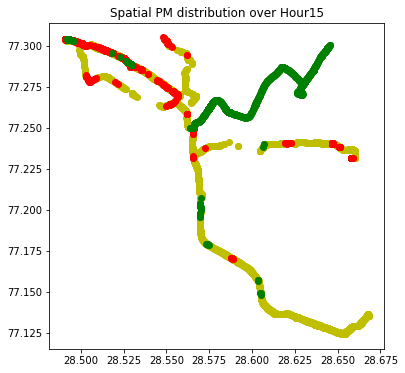

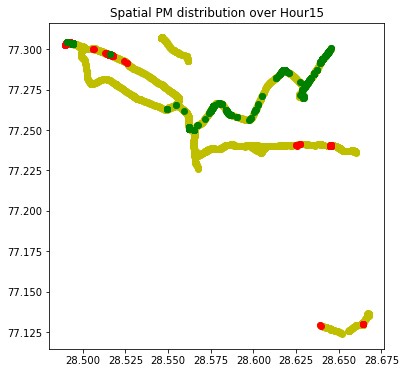

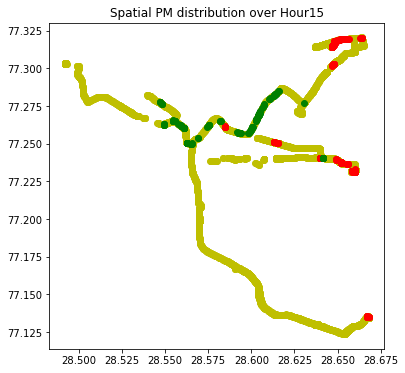

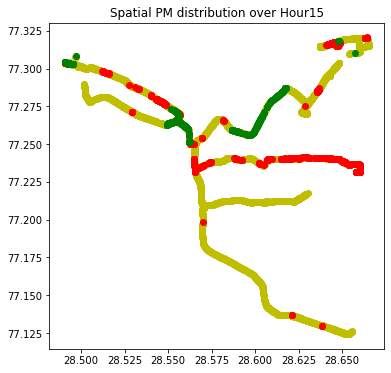

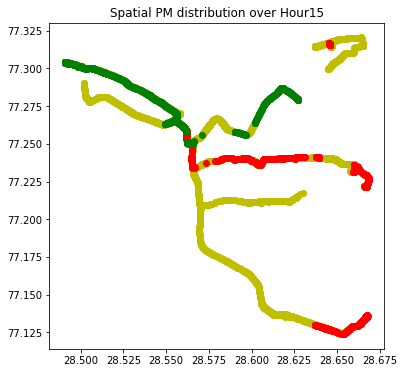

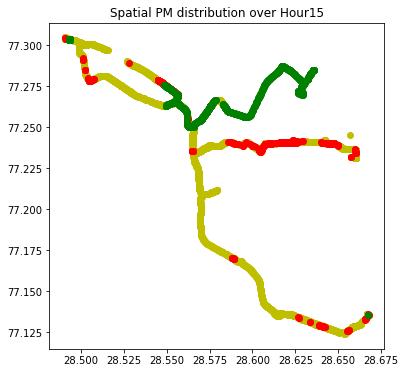

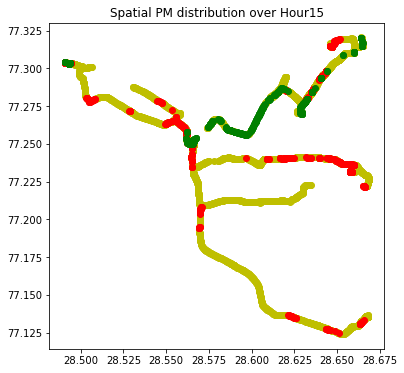

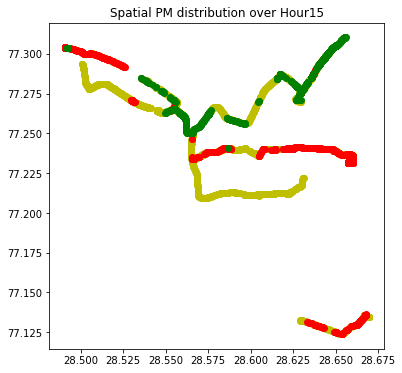

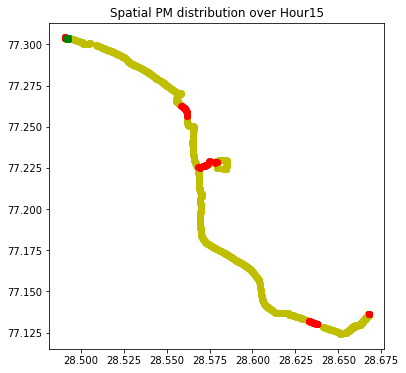

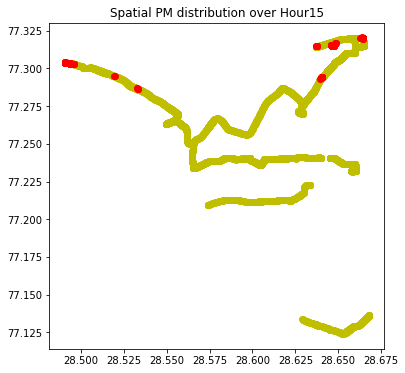

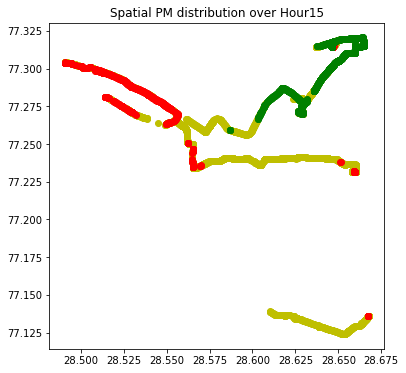

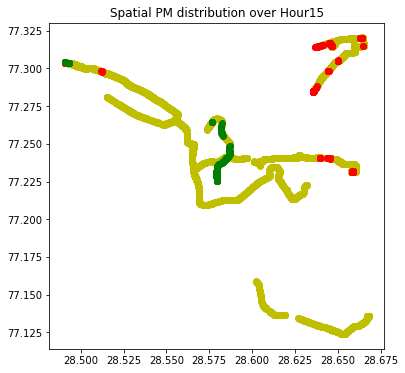

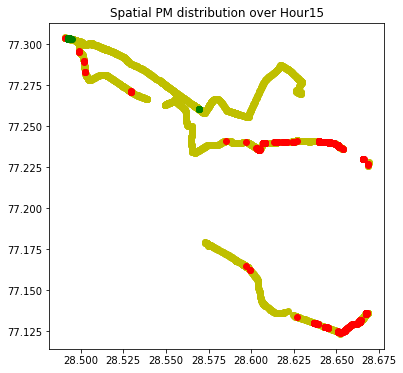

In [208]:
# plt.figure(figsize=(8, 6))
for i in range(1, 31):
    if i<10:
        datafile = 'PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = 'PM Datasets/2021-01-' + str(i) + '_all.csv'
    hourly_spatial(datafile, 2021, 1, i, 15)

# Autocorrelation with lag

In [5]:
def time_series(datafile):
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]

    # df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    # df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    # df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    # df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @120min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    df = df[(df.dateTime>=360)] 
    df = df[['pm2_5', 'dateTime']]
    df = df.groupby(['dateTime']).mean()
    df = df.reset_index()
    df = df.fillna(0)
    
    return df

In [9]:
#average PM2.5 values over all locations with 3-hr time windows on 1-7Dec
df = time_series('../PM Datasets/2020-12-01_all.csv')
for i in range(2, 8):
    datafile = '../PM Datasets/2020-12-'
    datafile +=  str(0) + str(i) if i<10 else str(i)
    datafile +=  '_all.csv'
    df1 = time_series(datafile)
    df = pd.concat([df,df1], axis=0)
    df = df.fillna(0)
df = df.reset_index()
df.head()

index  dateTime       pm2_5
0      0       360  283.206119
1      1       540  293.020763
2      2       720  234.010619
3      3       900  163.774823
4      4      1080  214.110167

In [10]:
# df = pd.read_csv('Dummy_data_1week_7Dec.csv')
# df = df.set_index(['lat_grid','long_grid'])
# df_temp = df.loc[1, 22].reset_index()
# df_temp.columns = [['time', 'pm2_5']]
# df_pm = df_temp['pm2_5']
# df_pm.head()

<AxesSubplot:>

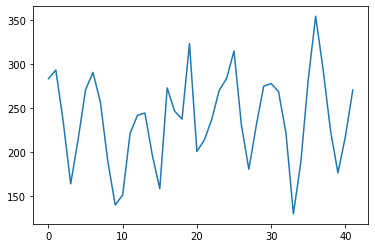

In [11]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
df['pm2_5'].plot()

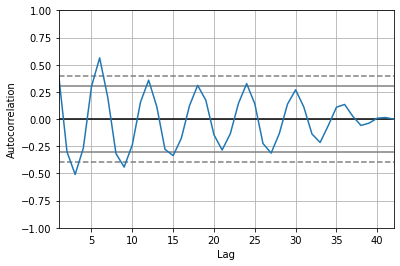

In [12]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['pm2_5'])
plt.show()

/efs/litmus-server/users/yguptgau/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


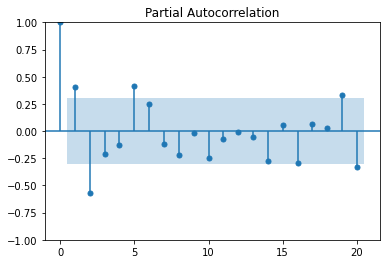

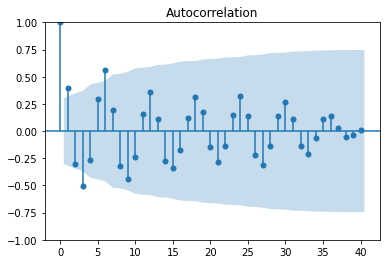

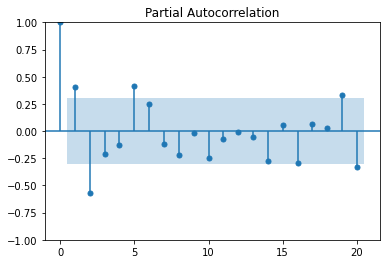

In [13]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['pm2_5'].values.tolist(), lags=40)
plot_pacf(df['pm2_5'].values.tolist(), lags=20)

In [14]:
df['PM First Difference'] = df['pm2_5'] - df['pm2_5'].shift(1)
df['Seasonal First Difference']=df['pm2_5']-df['pm2_5'].shift(6)
df.head()

index  dateTime       pm2_5  PM First Difference  Seasonal First Difference
0      0       360  283.206119                  NaN                        NaN
1      1       540  293.020763             9.814644                        NaN
2      2       720  234.010619           -59.010144                        NaN
3      3       900  163.774823           -70.235796                        NaN
4      4      1080  214.110167            50.335344                        NaN

<AxesSubplot:>

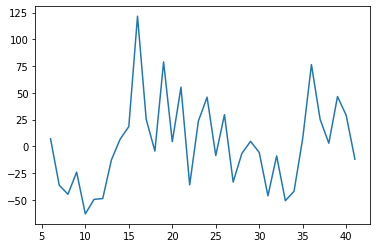

In [15]:
df['Seasonal First Difference'].plot()

/efs/litmus-server/users/yguptgau/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


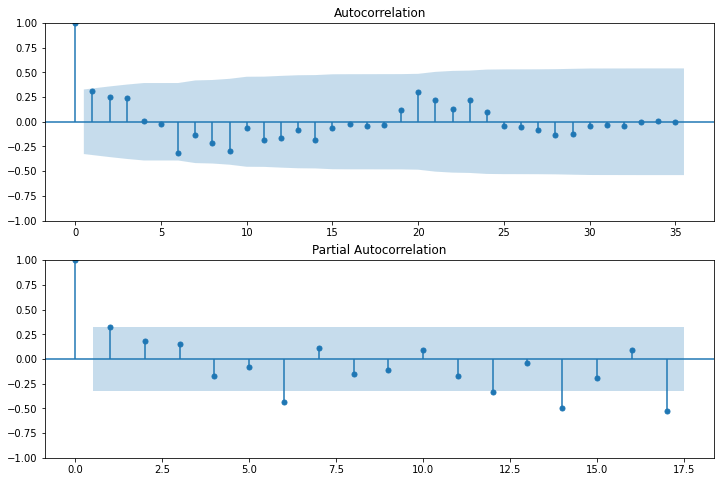

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=35,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=17,ax=ax2)

# Missing data

In [1]:
def data_preparation_miss(datafile):
    lat_range = {'min': 28.486, 'max': 28.72}
    long_range = {'min': 77.1, 'max': 77.32}
    n_lat_grid = 25
    n_long_grid = 25
    
    #Put the file location
    df = pd.read_csv(datafile)
    #type casting
    df.pm1_0 = df.pm1_0.astype(float)
    df.pm2_5 = df.pm2_5.astype(float)
    df.pm10 = df.pm10.astype(float)
    df.lat = round(round(5*df.lat.astype(float),2)/5.0,3)
    df.long= round(round(5*df.long.astype(float),2)/5.0,3)

    # Ensuring Delhi region and removing outliers from data
    df = df[(df.lat.astype(int) == 28) &(df.long.astype(int) == 77)]
    df = df[(df.pm1_0<=1500) & (df.pm2_5<=1500) & (df.pm10<=1500) & (df.pm1_0>=20) & (df.pm2_5>=30) & (df.pm10>=30)]
    #df = df[(df.humidity<=60)&(df.humidity>=7)]

    df['lat_grid'] = df.apply(lambda row: int((n_lat_grid-1)*(row.lat-lat_range['min'])/(lat_range['max']-lat_range['min'])), axis=1 )
    df['long_grid'] = df.apply(lambda row: int((n_long_grid-1)*(row.long-long_range['min'])/(long_range['max']-long_range['min'])), axis=1 )
    df['lat_grid'] = df['lat_grid'].astype(float).astype(int)
    df['long_grid'] = df['long_grid'].astype(float).astype(int)

    # rounding @180min
    df.dateTime = pd.to_datetime(df.dateTime)
    df.dateTime = df.dateTime.dt.round('180min')
    # use time as a feature as well
    df.dateTime = df.dateTime.dt.hour*60 + df.dateTime.dt.minute
    #taking only data from 6Am-12midnight
#     df = df[(df.dateTime>=360)] 
    df = df.pivot_table(index=['lat_grid','long_grid'], columns='dateTime', aggfunc='mean')['pm2_5']
#     df = df.fillna(0)
    return df

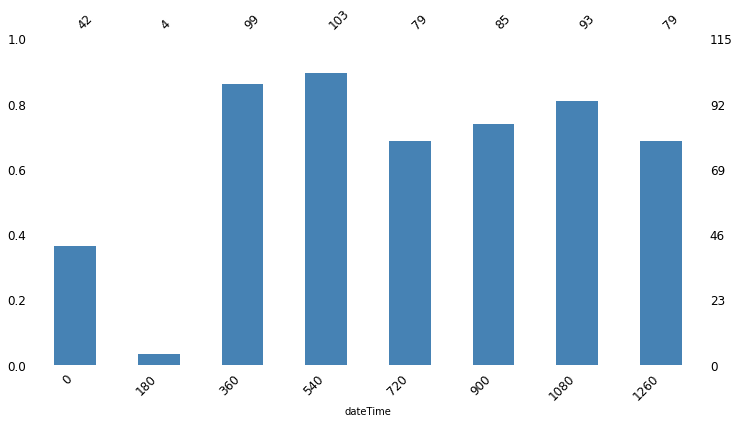

In [3]:
import pandas as pd
df = data_preparation_miss('../PM Datasets/2020-12-07_all.csv')
import missingno as msno
import matplotlib.pyplot as plt
msno.bar(df, figsize=(12, 6), fontsize=12, color='steelblue')

In [23]:
df = pd.DataFrame()
for i in range(1, 31):
    if i<10:
        datafile = '../PM Datasets/2020-11-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = '../PM Datasets/2020-11-' + str(i) + '_all.csv'
    df1 = data_preparation_miss(datafile)
    df1 = df1.notnull().mean().to_frame().T
    df = pd.concat([df, df1])

In [24]:
for i in range(1, 32):
    if i<10:
        datafile = '../PM Datasets/2020-12-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = '../PM Datasets/2020-12-' + str(i) + '_all.csv'
    df1 = data_preparation_miss(datafile)
    df1 = df1.notnull().mean().to_frame().T
    df = pd.concat([df, df1])

In [25]:
for i in range(1, 31):
    if i<10:
        datafile = '../PM Datasets/2021-01-' + str(0) + str(i) + '_all.csv'
    else:
        datafile = '../PM Datasets/2021-01-' + str(i) + '_all.csv'
    df1 = data_preparation_miss(datafile)
    df1 = df1.notnull().mean().to_frame().T
    df = pd.concat([df, df1])

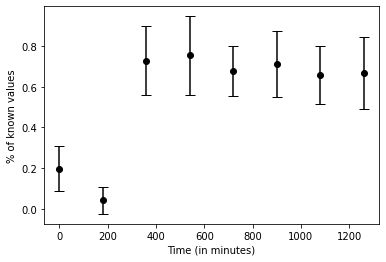

In [30]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
means = df.mean()
stds = df.std()
time = [0, 180, 360, 540, 720, 900, 1080, 1260]
plt.errorbar(time, means, yerr= stds, fmt='ok', capsize=5)
plt.xlabel("Time (in minutes)")
plt.ylabel("% of known values")
plt.savefig('missing_values.png')
plt.show()


In [31]:
means

dateTime
0       0.196242
180     0.040372
360     0.729308
540     0.754416
720     0.677969
900     0.713034
1080    0.658085
1260    0.668169
dtype: float64